In [1]:
import matplotlib as mpl
from numpy import dtype


mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import polars as pl
import itertools
import warnings
from scipy.sparse import csr_matrix
from scipy import stats
import scipy.ndimage as ndimage
from textwrap import wrap

import cvxpy as cp


sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set_context("paper")
warnings.filterwarnings(action='ignore')

RELOAD_ACCESSION_DATA = False

In [2]:
def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

complex_ids = read_names("data/complex_ids.txt")
monomer_ids = read_names("data/protein_ids.txt")
cofactor_ids = read_names("data/cofactor_ids.txt")
element_ids = read_names("data/element_ids.txt")
protein_ids = complex_ids.tolist() + monomer_ids.tolist()

# Reading the matrix CSV files
def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()

C = read_matrix("data/C_matrix.csv", sparse=True)
P = read_matrix("data/P_matrix.csv", sparse=True)
E = read_matrix("data/E_matrix.csv", sparse=True)
Tree = read_matrix("data/tree_matrix.csv", sparse=True)
tree_ids = complex_ids.tolist() + monomer_ids.tolist() + cofactor_ids.tolist()

total_counts_min = read_matrix("data/counts.csv")

element_isotope_mapping = {"MG": "25Mg", "MG2": "26Mg", "GA": "71Ga", "GE":"73Ge", "SI": "29Si", "P": "31P", "S": "34S", "CA":"44Ca",
                           "MN": "55Mn", "CU": "63Cu", "MO": "95Mo", "NI": "60Ni", "FE":"56Fe", 
                           "ZN": "66Zn", "W": "182W", "CO": "59Co",
                           "CD": "111Cd", "PB": "208Pb", "CR": "52Cr", "V": "51V", "SE": "77Se", "HG": "202Hg", "AS": "75As", "SB": "121Sb", "TL": "205Tl",
                           "AL": "27Al", "TI": "47Ti", "TI2": "48Ti", "FE2": "57Fe", "IN": "115In", "SN": "118Sn","BI": "209Bi",}
# reverse mapping
isotope_element_mapping = {v: k for k, v in element_isotope_mapping.items()}

## import conversion table

In [3]:
conversion_df = pl.read_csv("external_data/metalloproteome_exp_conversion.csv")

# get all unique values of End and Index
end_values = conversion_df["End"].unique().to_list()
index_values = conversion_df["Index"].unique().to_list()

# give each unique value a unique number
end_dict = {end: i for i, end in enumerate(end_values)}
index_dict = {index: i for i, index in enumerate(index_values)}

# create a new column for the unique value
conversion_df = conversion_df.with_columns(x=pl.col("End").replace(end_dict))
conversion_df = conversion_df.with_columns(y=pl.col("Index").replace(index_dict))

# drop start end index
conversion_df = conversion_df.drop(["Start", "End", "Index"])

conversion_df

Experiment,x,y
str,i64,i64
"""0to0_1""",0,0
"""0to0_2""",0,1
"""0to0_3""",0,2
"""0to0_4""",0,3
"""0to0_5""",0,4
…,…,…
"""900to1000_28""",17,27
"""900to1000_29""",17,28
"""900to1000_30""",17,29


In [4]:
conversion_df.unique("y")

Experiment,x,y
str,i64,i64
"""0to0_24""",0,23
"""0to0_10""",0,9
"""0to0_9""",0,8
"""0to0_15""",0,14
"""0to0_26""",0,25
…,…,…
"""0to0_19""",0,18
"""0to0_14""",0,13
"""0to0_4""",0,3


In [5]:
# load gene df
gene_df = pl.read_csv("data/accession_gene_dict.csv")

# convert to dict
gene_dict = dict(zip(gene_df["Accession Number"], gene_df["Gene Name"]))

gene_df

Accession Number,Gene Name
str,str
"""AAC76954.1""","""tufB"""
"""AAC76345.1""","""rplC"""
"""AAC76328.1""","""rpsE"""
"""AAC74990.1""","""fliC"""
"""AAC77103.1""","""groL"""
…,…
"""AAC75718.1""","""ygaC"""
"""AAC73987.1""","""ycaK"""
"""AAC77128.1""","""miaA"""


## Change column to gene name

In [6]:
# Load the data
prot_df_raw = pl.read_csv('external_data/metalloproteome_proteins.csv')

# drop "#", "Visible?", "Starred?", "Molecular Weight"
prot_df = prot_df_raw.drop(["#", "Visible?", "Starred?", "Molecular Weight", "Taxonomy"])

prot_df.head(5)

# change column to gene name
prot_df = prot_df.with_columns(Gene=pl.col("Accession Number").replace(gene_dict))

# drop Identified Proteins (1235), Accession Number
prot_df = prot_df.drop(["Identified Proteins (1235)", "Accession Number"])

# drop duplicate rows with the same gene name
prot_df = prot_df.unique(subset=["Gene"], maintain_order=True)

# transpose and keep gene as column names
prot_exp_names = list(prot_df.columns)[:-1]
gene_names = prot_df["Gene"].to_list()

In [7]:
# transpose and keep gene as column names
prot_df = prot_df.drop(["Gene"]).transpose()
prot_df.columns = gene_names

# add a new column, "Experiment"
prot_df = prot_df.with_columns(pl.Series(name="Experiment", values=prot_exp_names))

# join with the conversion table
prot_df = prot_df.join(conversion_df, on="Experiment")

prot_df

tufB,rplC,rpsE,fliC,groL,rpsT,rplD,rplX,rplR,rpsL,rplO,rplM,rpsA,rplV,icd,ilvC,rpsG,rpsN,rplN,rplB,rpsU,rplA,rplU,rpmB,carB,metE,eno,fusA,rpoB,rpoC,rpsI,hupA,rpsS,gapA,dppA,rpmD,oppA,…,tdh,hemN,chaB,yjhU,putA,hemF,efeB,paaY,yciG,yidC,dnaQ,fliK,yrdB,ybhB,yfaY,dnaJ,ybeL,fliD,ubiJ,ydeI,eutL,rarA,uxaC,tcdA,nikA,tolQ,ydcI,yedD,murB,ygaC,ycaK,miaA,fruK,ubiF,Experiment,x,y
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_1""",0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_2""",0,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_3""",0,2
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_4""",0,3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_5""",0,4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_28""",17,27
0,0,6,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_29""",17,28
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_30""",17,29


## Load the metal data

In [8]:
# load metal data
metal_df = pl.read_csv('external_data/metalloproteome_metals.csv')

# drop columns that started with "_dupli"
metal_df = metal_df.drop([col for col in metal_df.columns if col.startswith("_dupli")])

# drop columns without names
metal_df = metal_df.drop([col for col in metal_df.columns if len(col) < 2])

# for all float cols, subtract minimum value
# for col in metal_df.columns:
#     if metal_df[col].dtype == pl.Float64:
#         metal_df = metal_df.with_columns(pl.Series(name=col, values=metal_df[col] - 0.999 * metal_df[col].min()))

# extract list of metals
metals = metal_df.columns[1:]

metal_df

Experiment,25Mg,26Mg,29Si,31P,34S,44Ca,71Ga,73Ge,27Al,47Ti,48Ti,51V,52Cr,55Mn,56Fe,57Fe,59Co,60Ni,63Cu,66Zn,75As,77Se,95Mo,111Cd,115In,118Sn,121Sb,182W,202Hg,208Pb,209Bi
str,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""0to0_1""",8823,11681,189919,328,3591,22496,38,6,86.974396,4.004968,5.167747,0.179796,0.876813,10.836837,10.552461,10.337697,0.057026,1.173599,0.500182,0.602304,0.0222,0.119779,0.117428,0.00104,-13.836556,0.09528,0.007665,40.403296,3.449361,0.016148,9.993649
"""0to0_2""",868,1179,180574,300,3436,7186,4,1,1.353013,0.095871,0.377731,0.108823,0.728478,6.006004,2.958434,2.69667,0.048106,1.077893,0.339914,0.524031,0.013567,0.299447,0.117188,0.000208,-13.536126,0.056937,0.007508,35.564532,2.891377,0.010286,10.862665
"""0to0_3""",831,1205,182317,291,3581,7155,1,0,1.516522,0.100229,0.403266,0.116908,0.722591,5.784571,3.121333,2.888219,0.056345,1.111941,0.300745,0.542167,0.013567,0.059889,0.114162,0.00104,-13.595515,0.044946,0.007039,37.500017,2.536294,0.00858,9.993649
"""0to0_4""",872,1080,184990,256,3621,7330,2,0,1.600319,0.082798,0.414614,0.112477,0.746018,5.556133,3.373253,3.177696,0.080347,1.251426,0.30058,0.603577,0.0259,0.029945,0.126954,0.001873,-13.555307,0.037981,0.006804,39.193624,2.58702,0.007826,8.907374
"""0to0_5""",1006,1303,183349,294,3635,7837,3,0,1.671855,0.069725,0.442581,0.117996,0.789342,5.53877,3.598385,3.239036,0.10545,1.430548,0.480732,0.702853,0.024667,0.239558,0.11815,0.002289,-13.657827,0.037335,0.009229,43.548493,3.347909,0.011981,8.255623
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""900to1000_28""",402,597,70454,322,3812,2631,0,0,1.099329,0.082724,0.189697,0.114594,0.271328,0.044113,1.119198,0.83295,0.006293,0.169676,0.18,0.172763,0.014881,0.159694,0.073712,0.0,-15.342357,0.021587,0.00541,18.588133,1.491532,0.003633,3.698081
"""900to1000_29""",431,557,71339,321,3947,2585,3,0,1.144876,0.078128,0.171669,0.112909,0.262306,0.041008,1.146955,0.85173,0.006668,0.180365,0.176192,0.168419,0.017362,0.031939,0.076596,0.000631,-15.345479,0.023709,0.004199,22.796756,1.789838,0.003382,4.88147
"""900to1000_30""",743,946,67673,268,3814,2738,1,0,1.115892,0.045958,0.195433,0.108098,0.225865,0.070682,1.009749,0.69928,0.00599,0.202633,0.174884,0.269673,0.019842,0.127755,0.074627,0.000421,-15.180415,0.022758,0.004441,16.133086,2.336734,0.004481,4.141853


<Axes: ylabel='66Zn'>

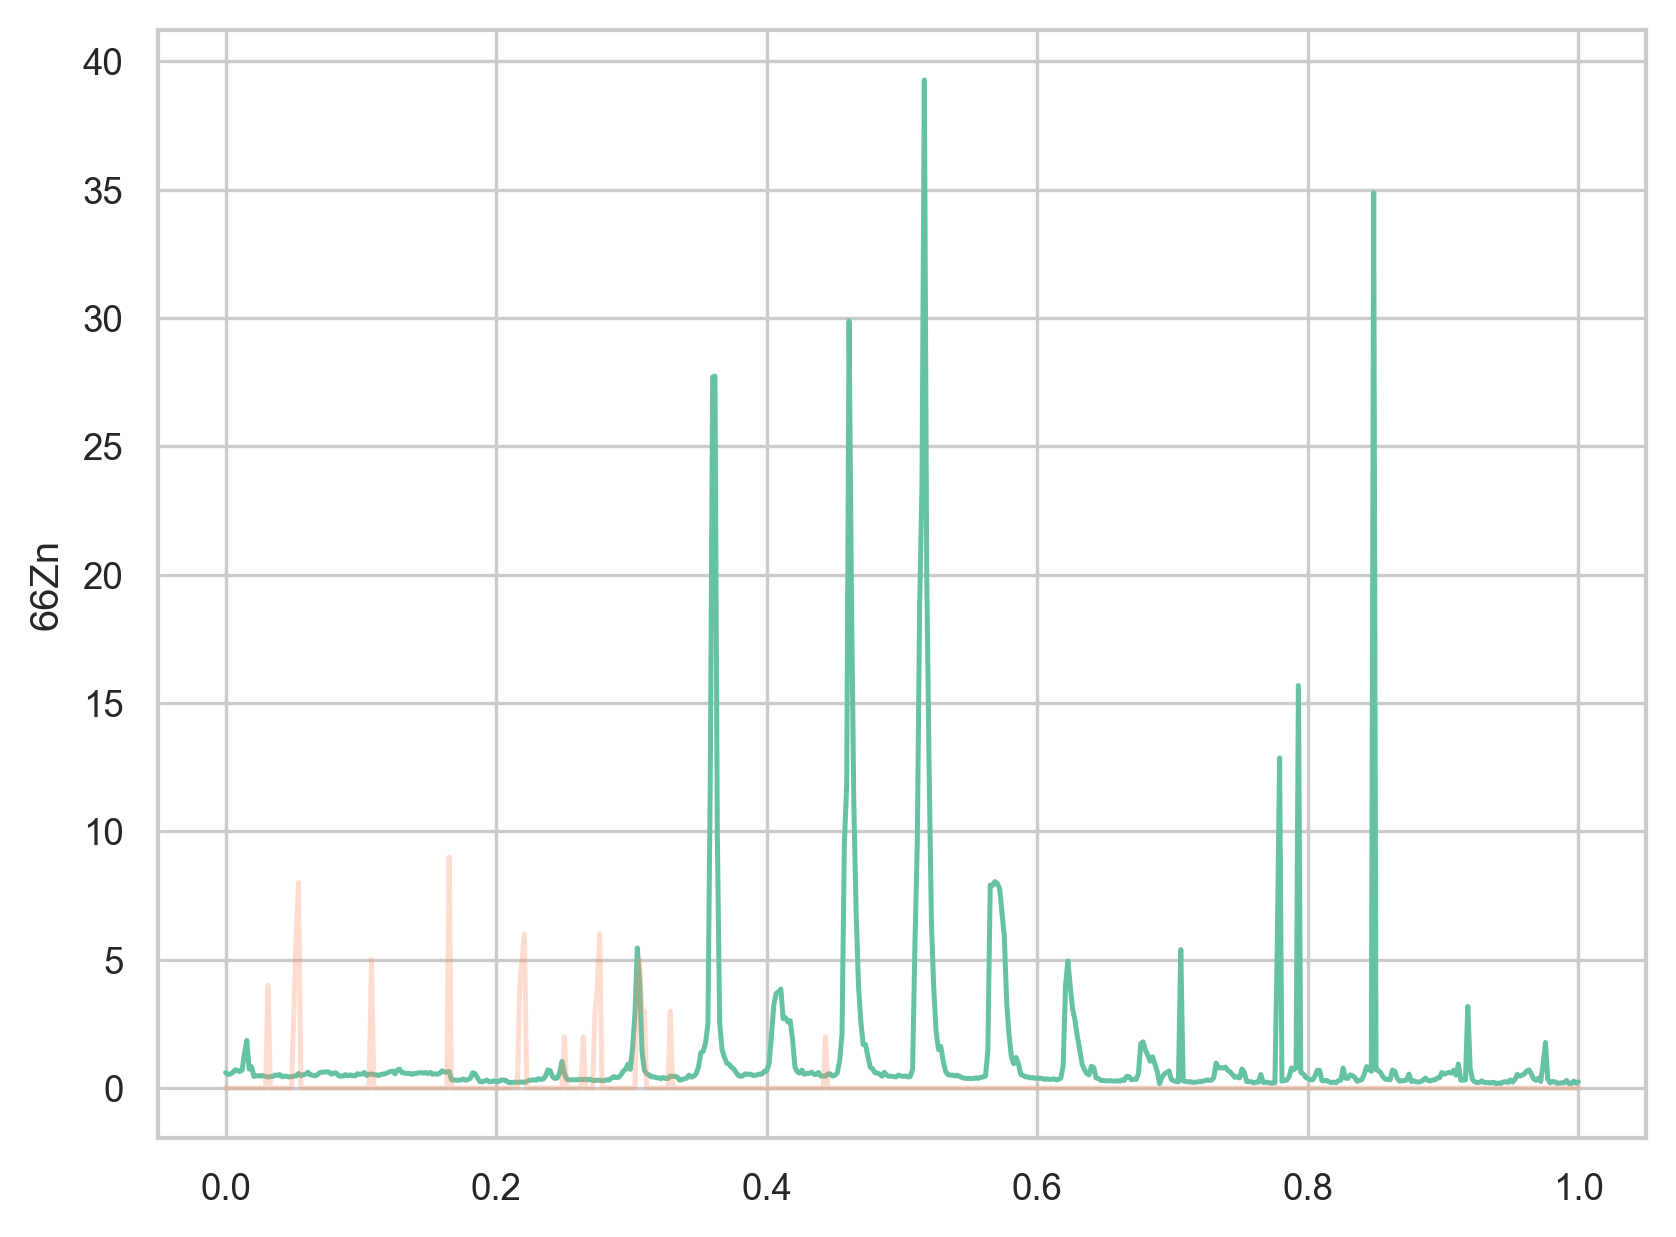

In [9]:
n_samples  = metal_df.shape[0]
linspace = np.linspace(0, 1, n_samples)

sns.lineplot(x=linspace, y="66Zn", data=metal_df)

# plot rpmE col
sns.lineplot(x=linspace, y="rpmE", data=prot_df, alpha=0.3)

# Join the metalloproteome data with the conversion table

In [10]:
# join the data
metal_join_df = metal_df.join(conversion_df, on="Experiment")

x_min = 3
y_min = 1

x_max = 15
y_max = 26


# filter out edges
# if x or y are 0, or x=17 or y=31, remove them.
metal_join_df = metal_join_df.filter((pl.col("x") >= x_min) & (pl.col("y") >= y_min) & (pl.col("x") <= x_max) & (pl.col("y") <=y_max))
prot_df = prot_df.filter((pl.col("x") >= x_min) & (pl.col("y") >= y_min) & (pl.col("x") <= x_max) & (pl.col("y") <= y_max))

metal_join_df

Experiment,25Mg,26Mg,29Si,31P,34S,44Ca,71Ga,73Ge,27Al,47Ti,48Ti,51V,52Cr,55Mn,56Fe,57Fe,59Co,60Ni,63Cu,66Zn,75As,77Se,95Mo,111Cd,115In,118Sn,121Sb,182W,202Hg,208Pb,209Bi,x,y
str,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
"""100to150_2""",2424,3268,358150,658,10318,10690,4,2,1.28963,0.105418,0.23391,0.20744,0.437886,0.994977,1.57962,1.247038,0.036616,0.831977,0.229864,0.30864,0.014489,0.200652,0.081377,0.001336,-13.40308,0.038449,0.004793,12.471815,2.004132,0.00593,4.187315,3,1
"""100to150_3""",2404,3293,353562,737,11082,10791,7,4,1.434155,0.086251,0.26326,0.189714,0.449281,0.965916,1.851357,1.489283,0.035843,0.854022,0.242732,0.302458,0.015648,0.183931,0.081209,0.000779,-13.505967,0.040625,0.005548,12.224868,2.077455,0.006276,3.513492,3,2
"""100to150_4""",2298,3197,346458,704,10499,10289,4,4,1.605376,0.103501,0.246314,0.187535,0.473168,0.947359,2.152927,1.808355,0.035271,0.819974,0.256623,0.304706,0.024341,0.16721,0.077411,0.001781,-13.331345,0.040189,0.005903,12.101366,2.321863,0.006496,3.248776,3,3
"""100to150_5""",2420,3155,341925,690,9885,10242,1,3,1.478341,0.093918,0.238977,0.168423,0.434999,0.926318,1.782944,1.457018,0.03481,0.787764,0.273798,0.312854,0.017386,0.066884,0.079091,0.000668,-13.197517,0.038805,0.005015,13.95364,2.24854,0.006416,3.561624,3,4
"""100to150_6""",2276,3048,329445,753,10192,10398,2,1,1.46177,0.113085,0.252254,0.170305,0.443807,0.90726,1.764867,1.436532,0.036868,0.797316,0.261809,0.34882,0.016227,0.183931,0.078738,0.001002,-13.089512,0.034137,0.004616,12.348343,2.224101,0.00667,3.3691,3,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""700to800_23""",687,1066,62194,282,3446,4018,0,1,0.968749,0.067557,0.266934,0.100142,0.235307,0.12268,1.015955,0.727855,0.008304,0.205888,0.172192,0.322502,0.021042,0.265612,0.074713,0.000638,-14.964736,0.022933,0.00529,20.51376,1.913082,0.004284,5.048914,15,22
"""700to800_24""",1032,1291,63460,280,3725,5395,1,1,2.75897,0.117098,0.31536,0.101578,0.232665,0.127879,1.182385,0.9304,0.009572,0.23914,0.192601,0.541271,0.017096,0.265612,0.091301,0.000638,-15.408186,0.083402,0.005208,19.536919,1.647375,0.005147,9.42467,15,23
"""700to800_25""",576,809,65263,326,3752,3352,1,1,1.023242,0.076564,0.206102,0.107803,0.262816,0.119358,1.022619,0.776596,0.008429,0.220881,0.171453,0.253877,0.015781,0.132806,0.076556,0.001064,-15.137232,0.026768,0.004394,14.327084,1.753658,0.004305,4.039135,15,24


<Axes: ylabel='66Zn'>

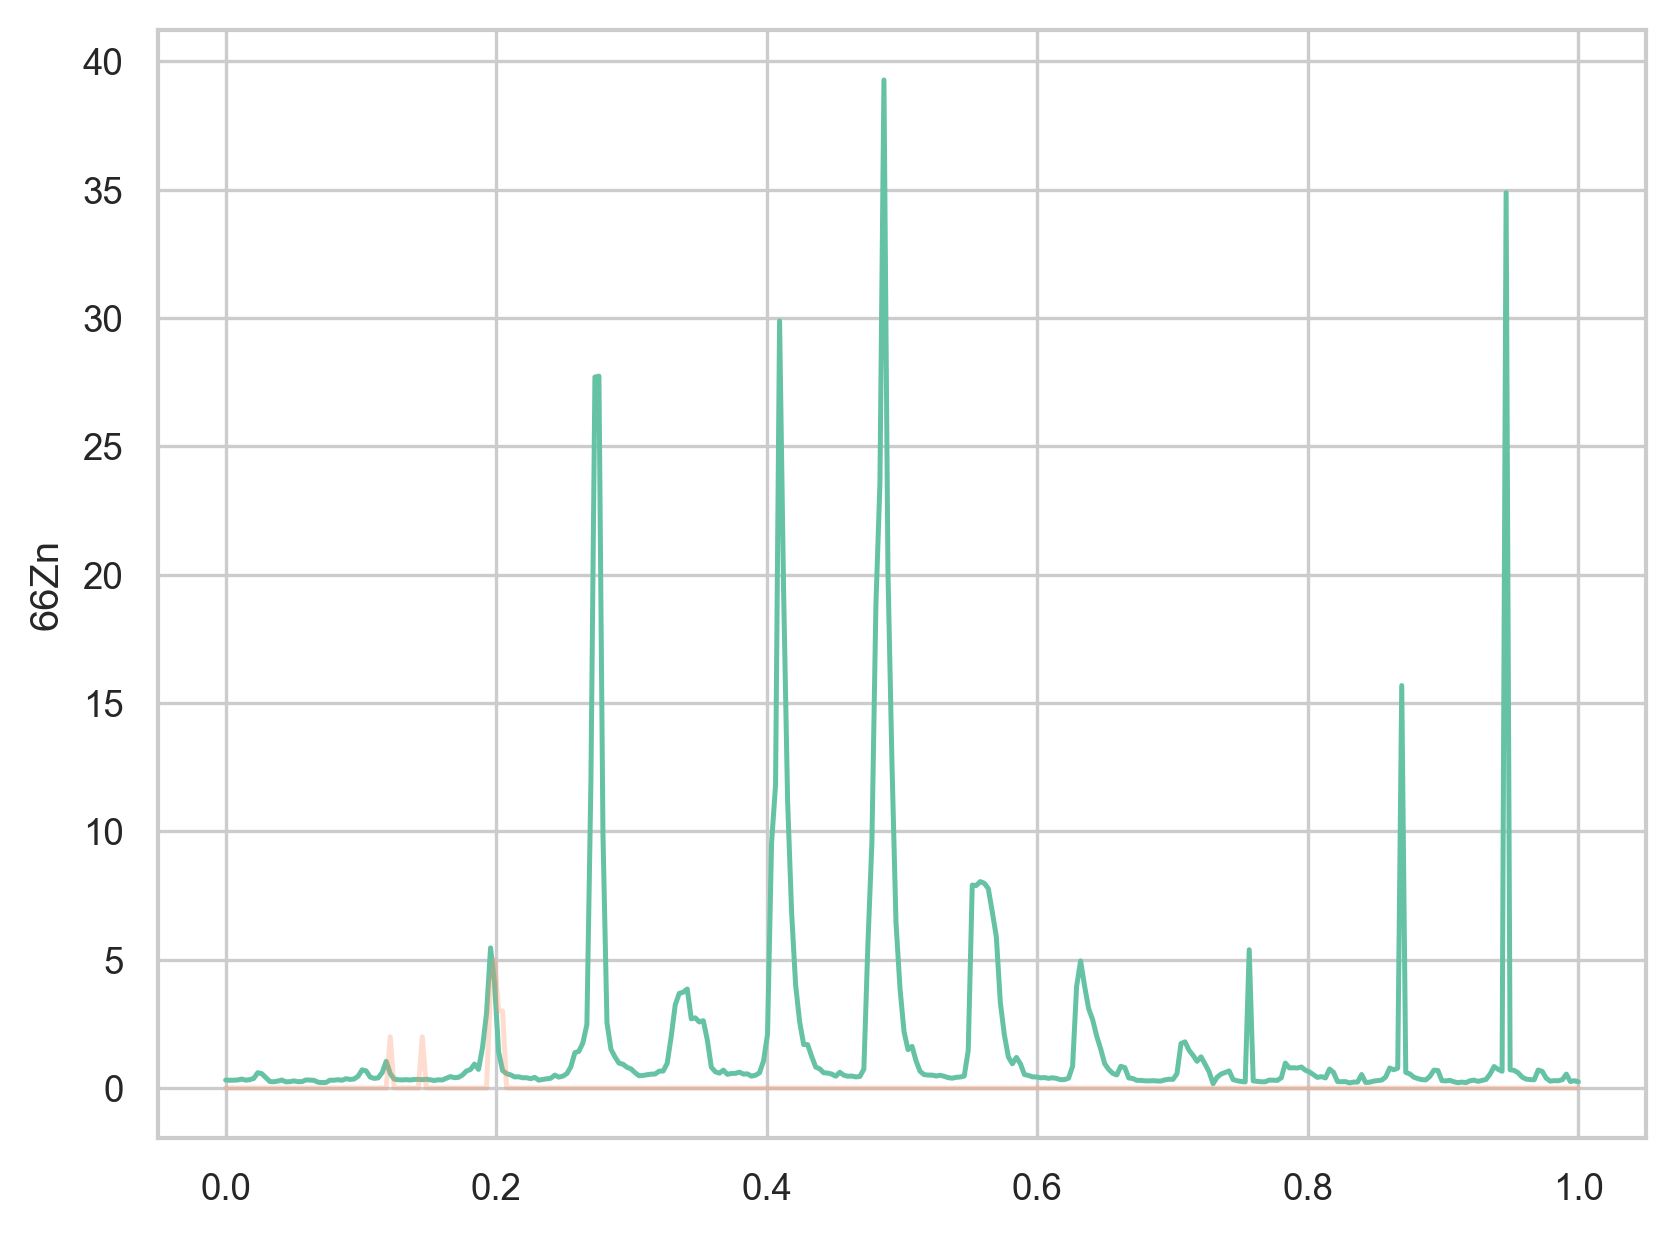

In [11]:
n_samples  = metal_join_df.shape[0]
linspace = np.linspace(0, 1, n_samples)

sns.lineplot(x=linspace, y="66Zn", data=metal_join_df)

# plot rpmE col
sns.lineplot(x=linspace, y="rpmE", data=prot_df, alpha=0.3)

# Import simulation data and conversion tables

In [12]:
# make protein-element mapping
elements = ["FE", "ZN", "MN", "CU", "MO", "NI"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]


# get name conversion table
gene_name_table = pl.read_csv("external_data/ecocyc_name_conversion.txt", separator="\t")

# rename cols to "Protein ID", "EcoCyc ID", "Accession Number", "Gene name"
gene_name_table.columns = ["Protein ID", "EcoCyc ID", "Accession Number", "Gene name"]

# get corresponding gene name for each protein
gene_name_table = gene_name_table.filter(pl.col("Protein ID").is_in(monomer_ids))

# make a mapping
gene_to_prot_dict = dict(zip(gene_name_table["Gene name"], gene_name_table["Protein ID"]))
prot_to_gene_dict = dict(zip(gene_name_table["Protein ID"], gene_name_table["Gene name"]))

# convert gene_names list to protein id list
detected_protein_ids = [gene_to_prot_dict[gene_name] for gene_name in gene_names if gene_name in gene_to_prot_dict]
# get indices of genes in gene dict
gene_indices = [gene_names.index(gene_name) for gene_name in gene_names if gene_name in gene_to_prot_dict]

# for each protein id, index it in the monomer_ids
detected_protein_idx = [monomer_ids.tolist().index(protein_id) for protein_id in detected_protein_ids]


In [13]:
monomer_to_complex_dict = {}

# create monomer to complex dict
for i, protein_id in enumerate(monomer_ids):
    if protein_id in monomer_ids:

        # get indices where C[:, i] is nonzero
        complex_indices = np.where(C[:, i].toarray() > 0)[0]

        # save complex_id if it doesn't match the protein_id
        complex_id = [protein_ids[idx] for idx in complex_indices if protein_ids[idx] != protein_id]

        # check in Tree if complex_id has parents by checking sum
        complex_parents = [Tree[:, tree_ids.index(complex_id)].sum() for complex_id in complex_id]

        # if complex_id doesn't have parents, select it
        for j, complex_id_idx in enumerate(complex_id):
            if complex_parents[j] == 0:
                monomer_to_complex_dict[protein_id] = complex_id[j]

                # if len(complex_id) > 1:
                    # print(f"Multiple complex ids found for protein: {protein_id}, complex ids: {complex_id}. Picked {complex_id[j]}")




In [14]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

sim_prot_metal = np.diag(total_counts_min.mean(axis=0) @ C) @ P @ E[:, element_indices]

# divide by col sums
sim_prot_metal = sim_prot_metal / sim_prot_metal.sum(axis=0)

sim_prot_metal_df = pl.DataFrame(sim_prot_metal, schema=elements)
sim_prot_metal_df = sim_prot_metal_df.with_columns(pl.Series(name="Protein ID", values=monomer_ids))
sim_prot_metal_df = sim_prot_metal_df.with_columns(pl.Series(name="Gene",
                                                             values=[prot_to_gene_dict[protein_id]  if protein_id in prot_to_gene_dict else "None" for protein_id in sim_prot_metal_df["Protein ID"]]))

# only include genes found in the experimental data
sim_prot_metal_df = sim_prot_metal_df.filter(pl.col("Gene").is_in(gene_names))

# use monomer_to_complex_dict to add complex id column by using polars replace
sim_prot_metal_df = sim_prot_metal_df.with_columns(pl.Series(name="Complex ID", values=sim_prot_metal_df["Protein ID"].replace(monomer_to_complex_dict)))


sim_prot_metal_df

FE,ZN,MN,CU,MO,NI,Protein ID,Gene,Complex ID
f64,f64,f64,f64,f64,f64,str,str,str
0.0,0.0,0.0,0.0,0.0,0.0,"""1-PFK-MONOMER""","""fruK""","""1-PFK"""
0.0,0.0,0.0,0.0,0.0,0.0,"""2-ISOPROPYLMALATESYN-MONOMER""","""leuA""","""2-ISOPROPYLMALATESYN-MONOMER"""
0.0,0.0,0.0,0.0,0.0,0.0,"""2-OCTAPRENYL-METHOXY-BENZOQ-ME…","""ubiE""","""CPLX0-8301"""
0.0,0.0,0.0,0.0,0.0,0.0,"""3-CH3-2-OXOBUTANOATE-OH-CH3-XF…","""panB""","""3-METHYL-2-OXOBUT-OHCH3XFER-CP…"
0.0,0.0,0.0,0.0,0.0,0.0,"""3-ISOPROPYLMALDEHYDROG-MONOMER""","""leuB""","""3-ISOPROPYLMALDEHYDROG-CPLX"""
…,…,…,…,…,…,…,…,…
0.0,0.0,0.0,0.0,0.0,0.0,"""YJJK-MONOMER""","""ettA""","""YJJK-MONOMER"""
0.0,0.0,0.0,0.0,0.0,0.0,"""YLIB-MONOMER""","""gsiB""","""ABC-49-CPLX"""
0.0,0.0,0.0,0.0,0.0,0.0,"""YNEA-MONOMER""","""lsrB""","""ABC-58-CPLX"""


# Plot unprocessed data

Text(0.5, 46.74999999999996, 'Ion chromatography fraction')

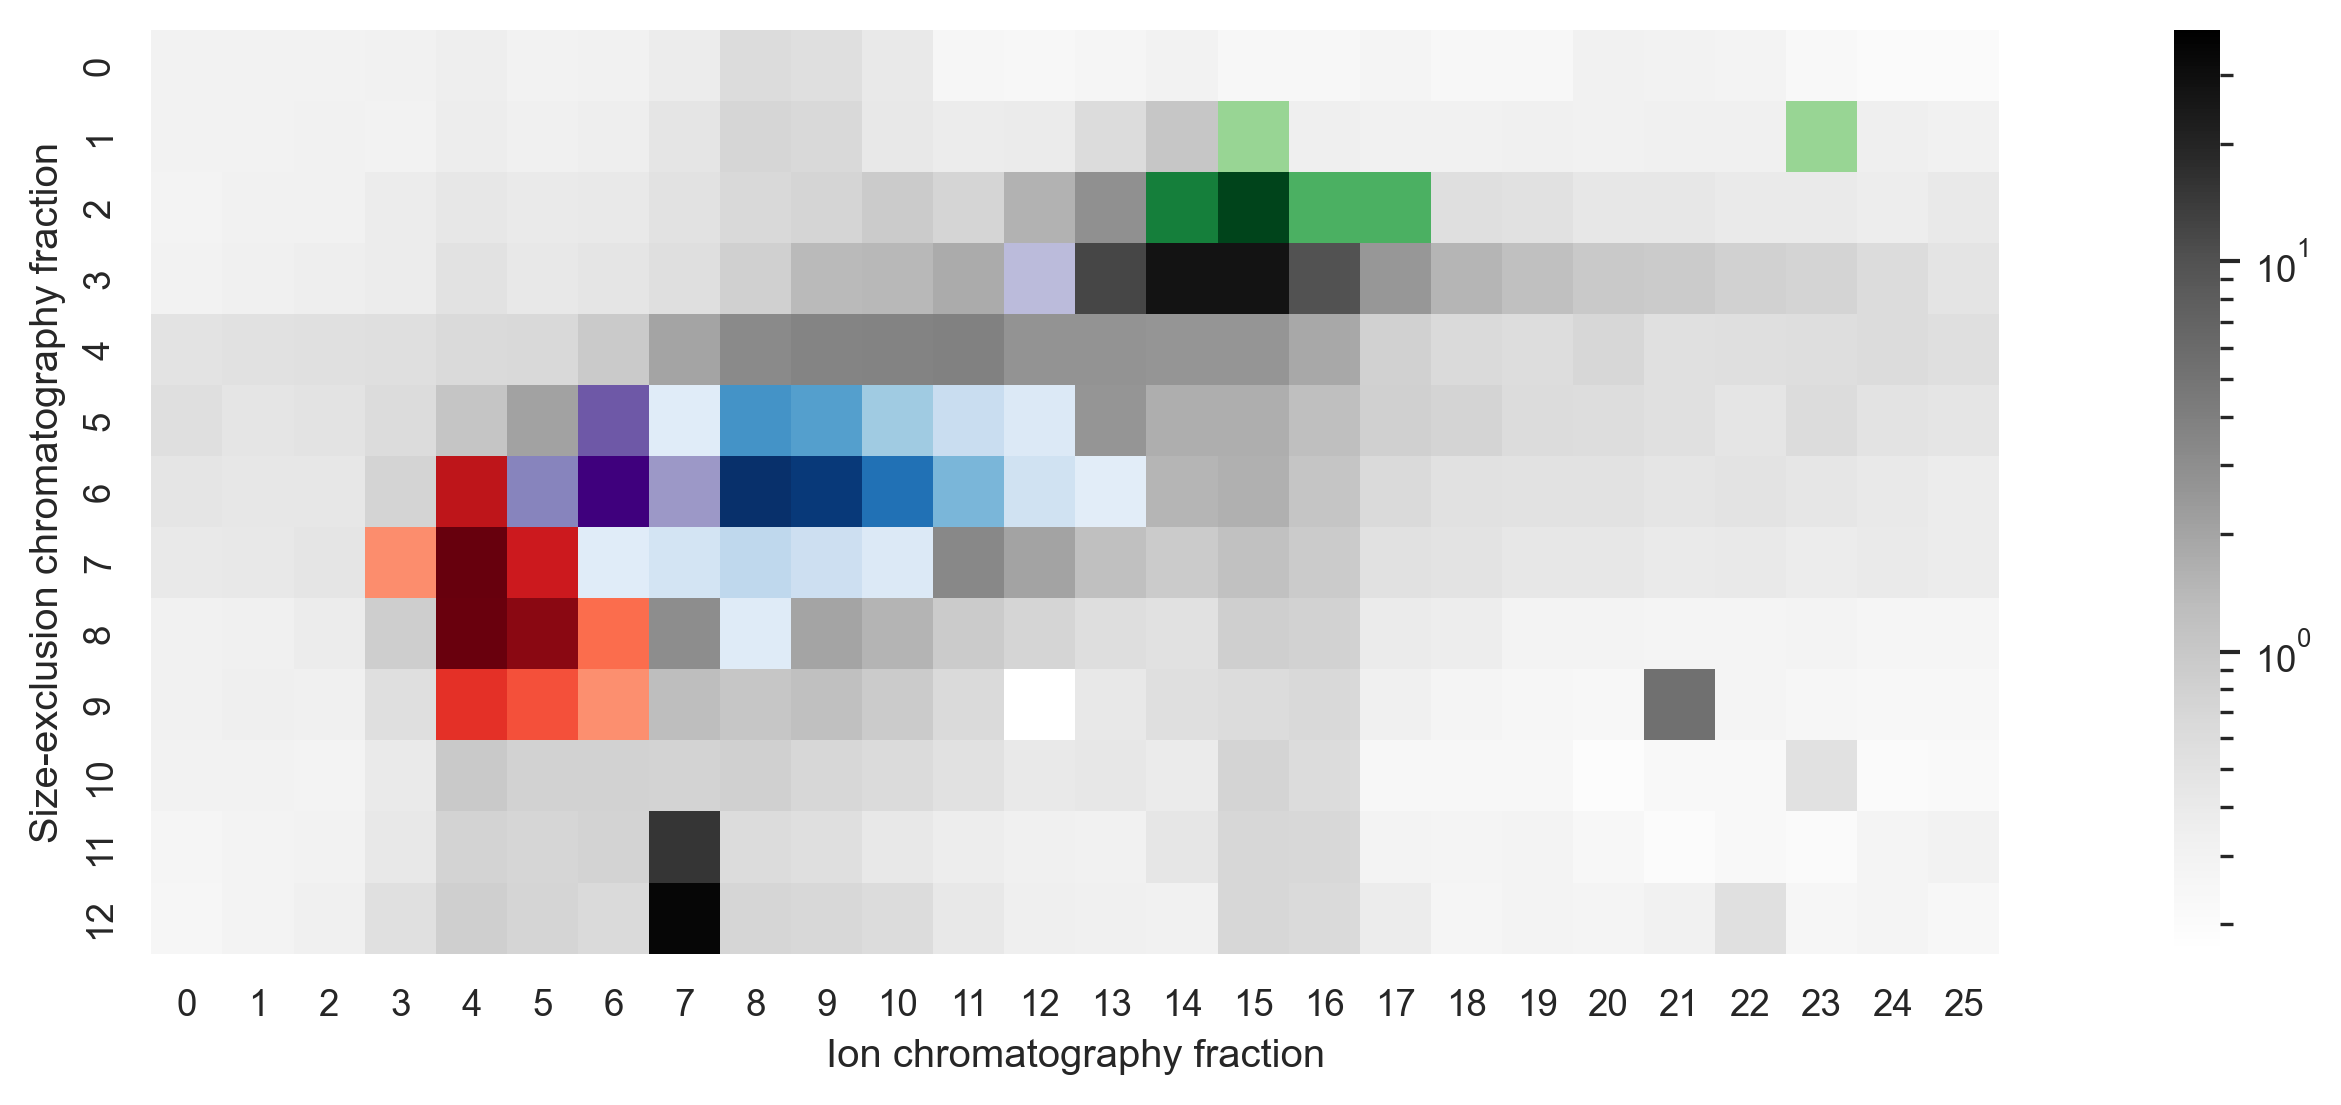

In [15]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(15, 4))

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot("66Zn", "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True, norm=LogNorm())
sns.heatmap(prot_df.pivot("metE", "x", "y", )[:, 1:], mask=(prot_df.pivot("metE", "x", "y", ) < 50).to_numpy()[:, 1:], 
            cmap="Blues", square=True, cbar=False, vmin=0)
sns.heatmap(prot_df.pivot("rpmE", "x", "y", )[:, 1:], mask=(prot_df.pivot("rpmE", "x", "y", ) < 1).to_numpy()[:, 1:], 
            cmap="Greens", square=True, vmin=0, cbar=False)
sns.heatmap(prot_df.pivot("rpoC", "x", "y", )[:, 1:], mask=(prot_df.pivot("rpoC", "x", "y", ) < 100).to_numpy()[:, 1:], 
            cmap="Reds", square=True, vmin=0, cbar=False)
sns.heatmap(prot_df.pivot("pyrI", "x", "y", )[:, 1:], mask=(prot_df.pivot("pyrI", "x", "y", ) < 80).to_numpy()[:, 1:], 
            cmap="Purples", square=True, vmin=0, cbar=False)

# change x and y axis labels
plt.ylabel("Size-exclusion chromatography fraction")
plt.xlabel("Ion chromatography fraction")

# make xticklabels and yticklabels start from x_min and y_min and end at x_max and y_max

# set xticklabels
# plt.xticks(np.arange(y_min, y_max, 1) - 0.5, np.arange(y_min, y_max, 1))
# plt.yticks(np.arange(x_min, x_max, 1) - 0.5, np.arange(x_min, x_max, 1))



# Plot grid of heatmaps

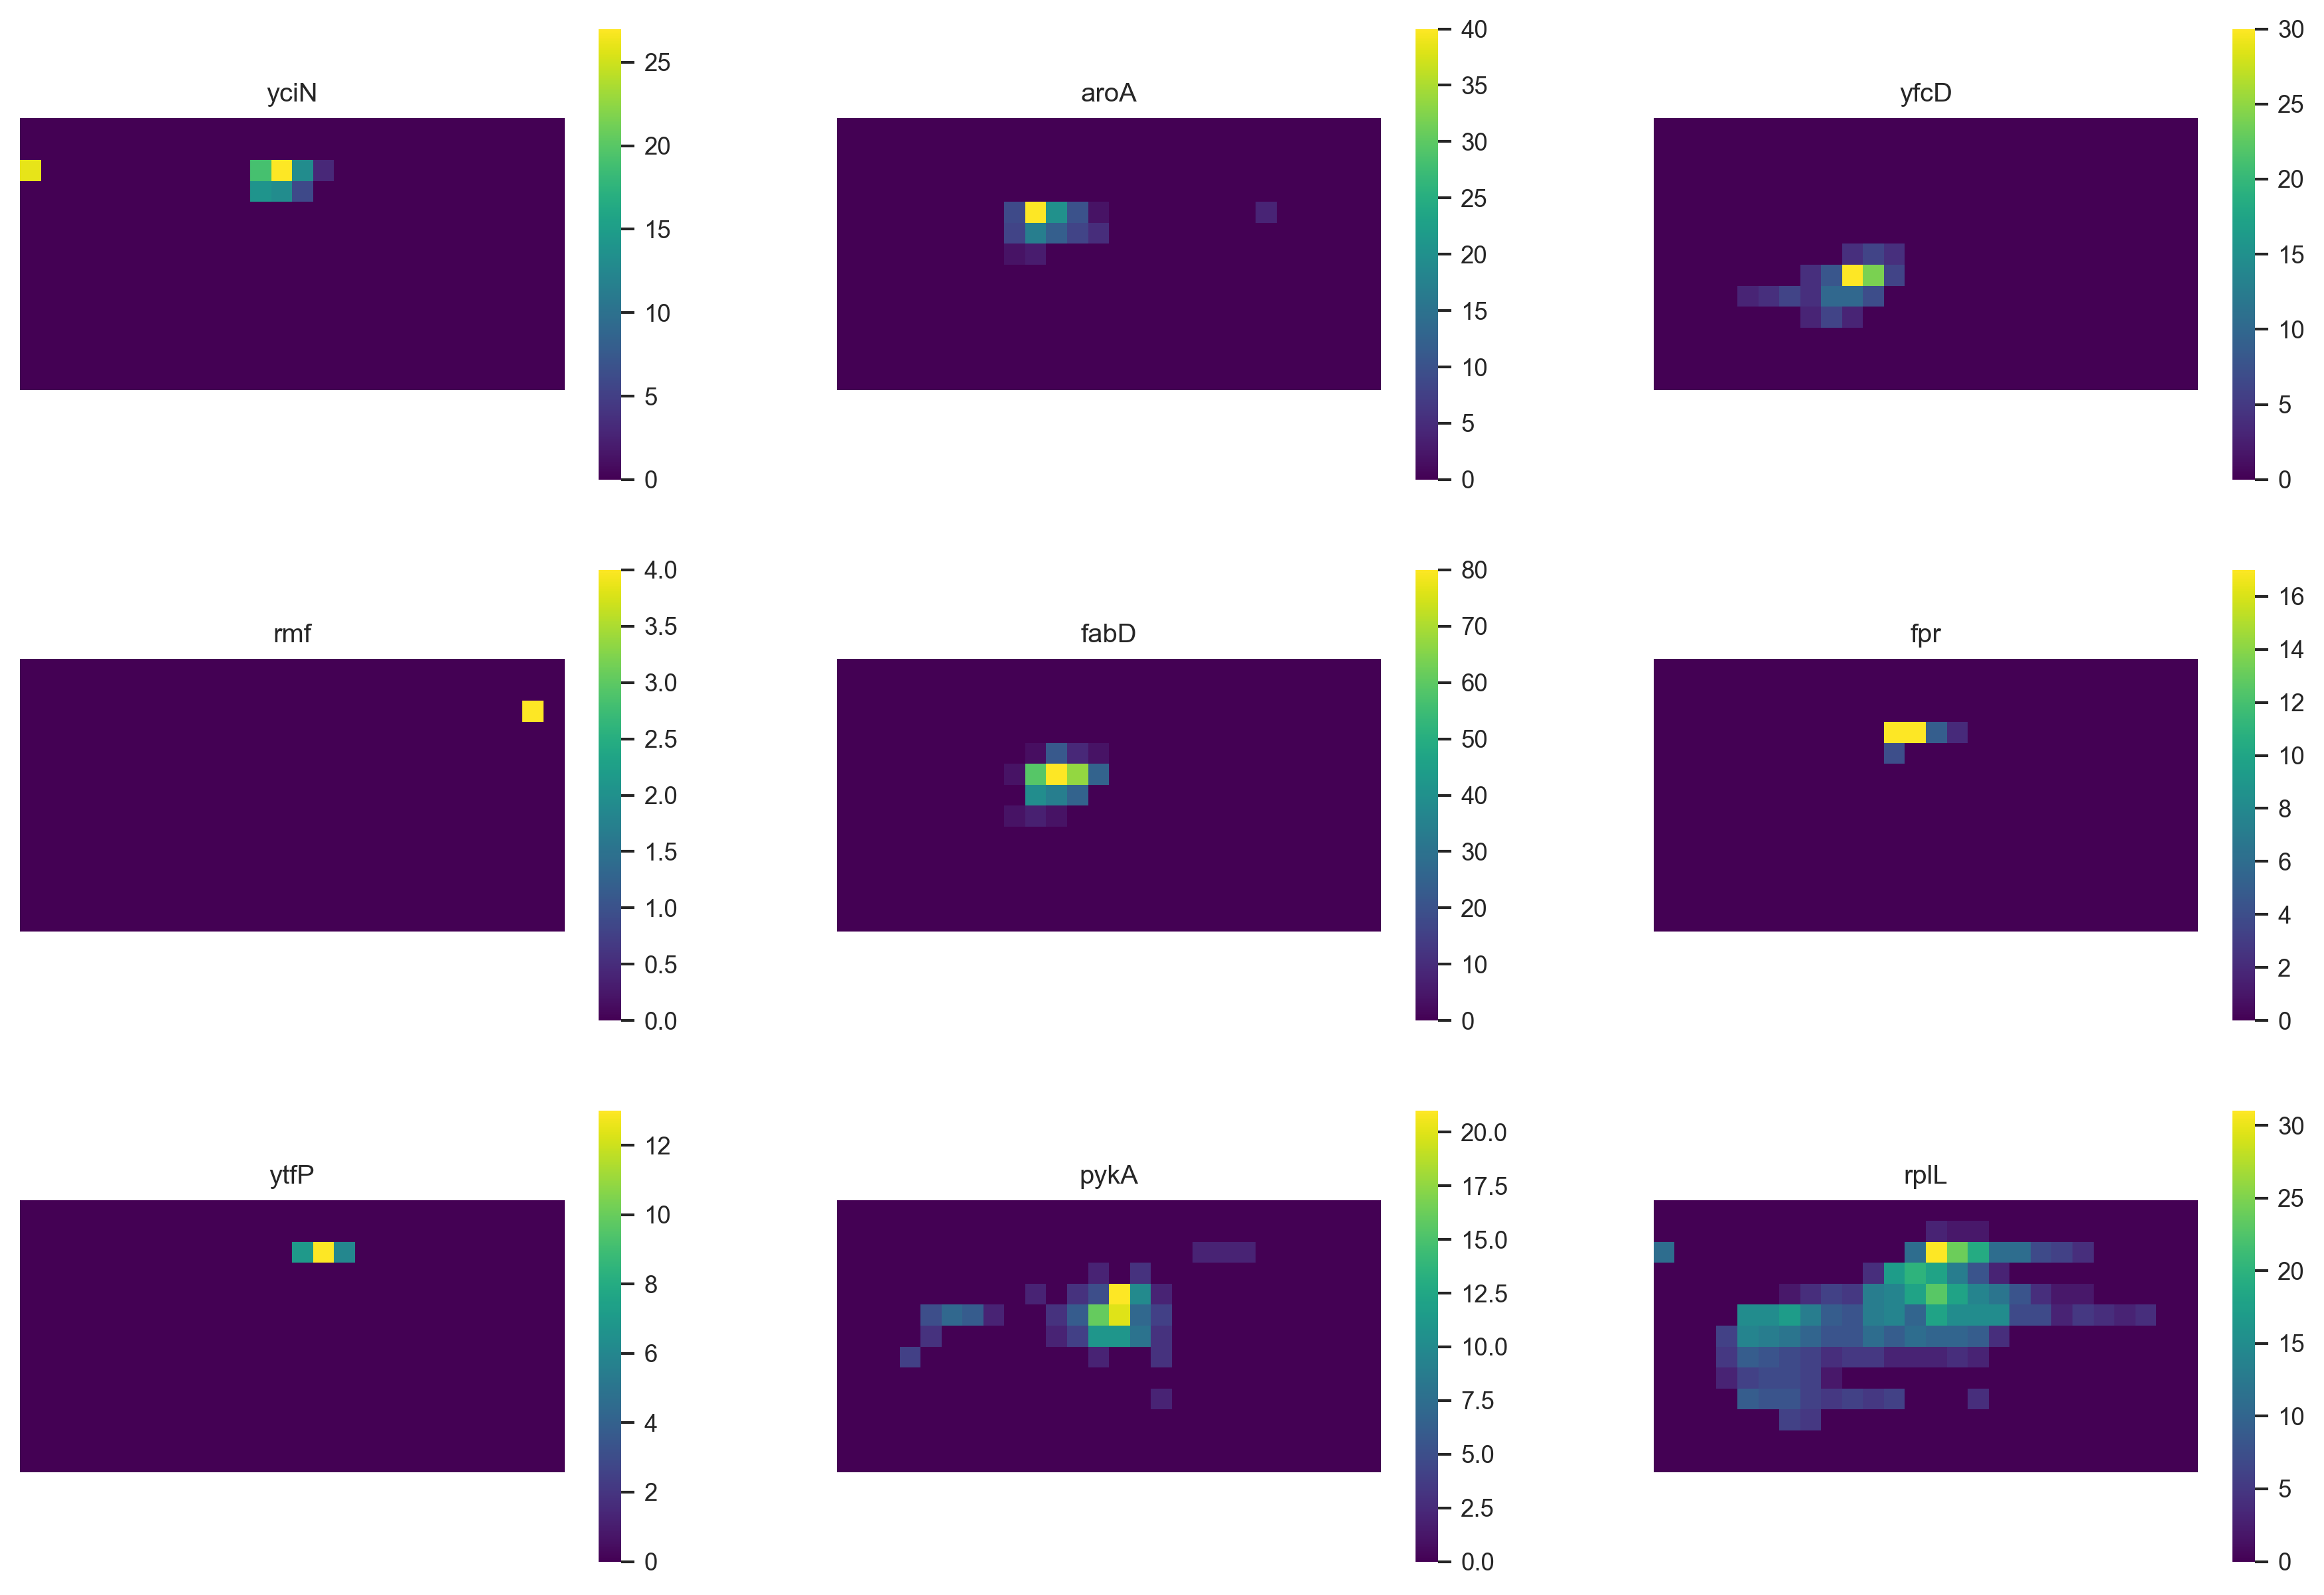

In [16]:
# for 9 random proteins, plot a grid of small heatmaps
random_proteins = np.random.choice(gene_names, 9)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
for i, ax in enumerate(axs.flatten()):
    sns.heatmap(prot_df.pivot(random_proteins[i], "x", "y", )[:, 1:], cmap="viridis", square=True, cbar=True, ax=ax)
    ax.set_title(random_proteins[i])
    ax.set_xticks([])
    ax.set_yticks([])

    ## Filter out edges

In [17]:
# For each protein, pivot and do some filtering

for protein in gene_names:
    prot_pivot = prot_df.pivot(protein, "x", "y", ).to_numpy()[:, 1:]

    # create boolean array
    prot_mask = prot_pivot > 0

    # find number of neighbours per well
    footprint = np.array([[1,1,1],
                          [1,0,1],
                          [1,1,1]])

    f = lambda x: x.sum()

    results = ndimage.generic_filter(prot_mask, f, footprint=footprint, mode="constant", cval=0)

    # get AND of the two
    prot_pivot_true_mask = prot_mask & results

    # dont zero if it would remove all the data
    if prot_pivot_true_mask.sum() > 0:
        prot_pivot[~prot_pivot_true_mask] = 0

    # set column as flattened pivot
    prot_df = prot_df.with_columns(pl.Series(name=protein, values=prot_pivot.flatten()))



In [18]:
# for specific wells with extreme outlier values, zero all metal masses.
problem_wells = [[11, 7], [12, 7], [9, 21]]
disable_wells = True

# loop through metal cols, pivot, and zero out the problem wells
if disable_wells == True:
    for metal in metals:
        metal_pivot = metal_join_df.pivot(metal, "x", "y", ).to_numpy()[:, 1:]
    
        # set to minimum value
        for well in problem_wells:
            metal_pivot[well[0], well[1]] = np.median(metal_pivot)
    
        # set column as flattened pivot
        metal_join_df = metal_join_df.with_columns(pl.Series(name=metal, values=metal_pivot.flatten()))


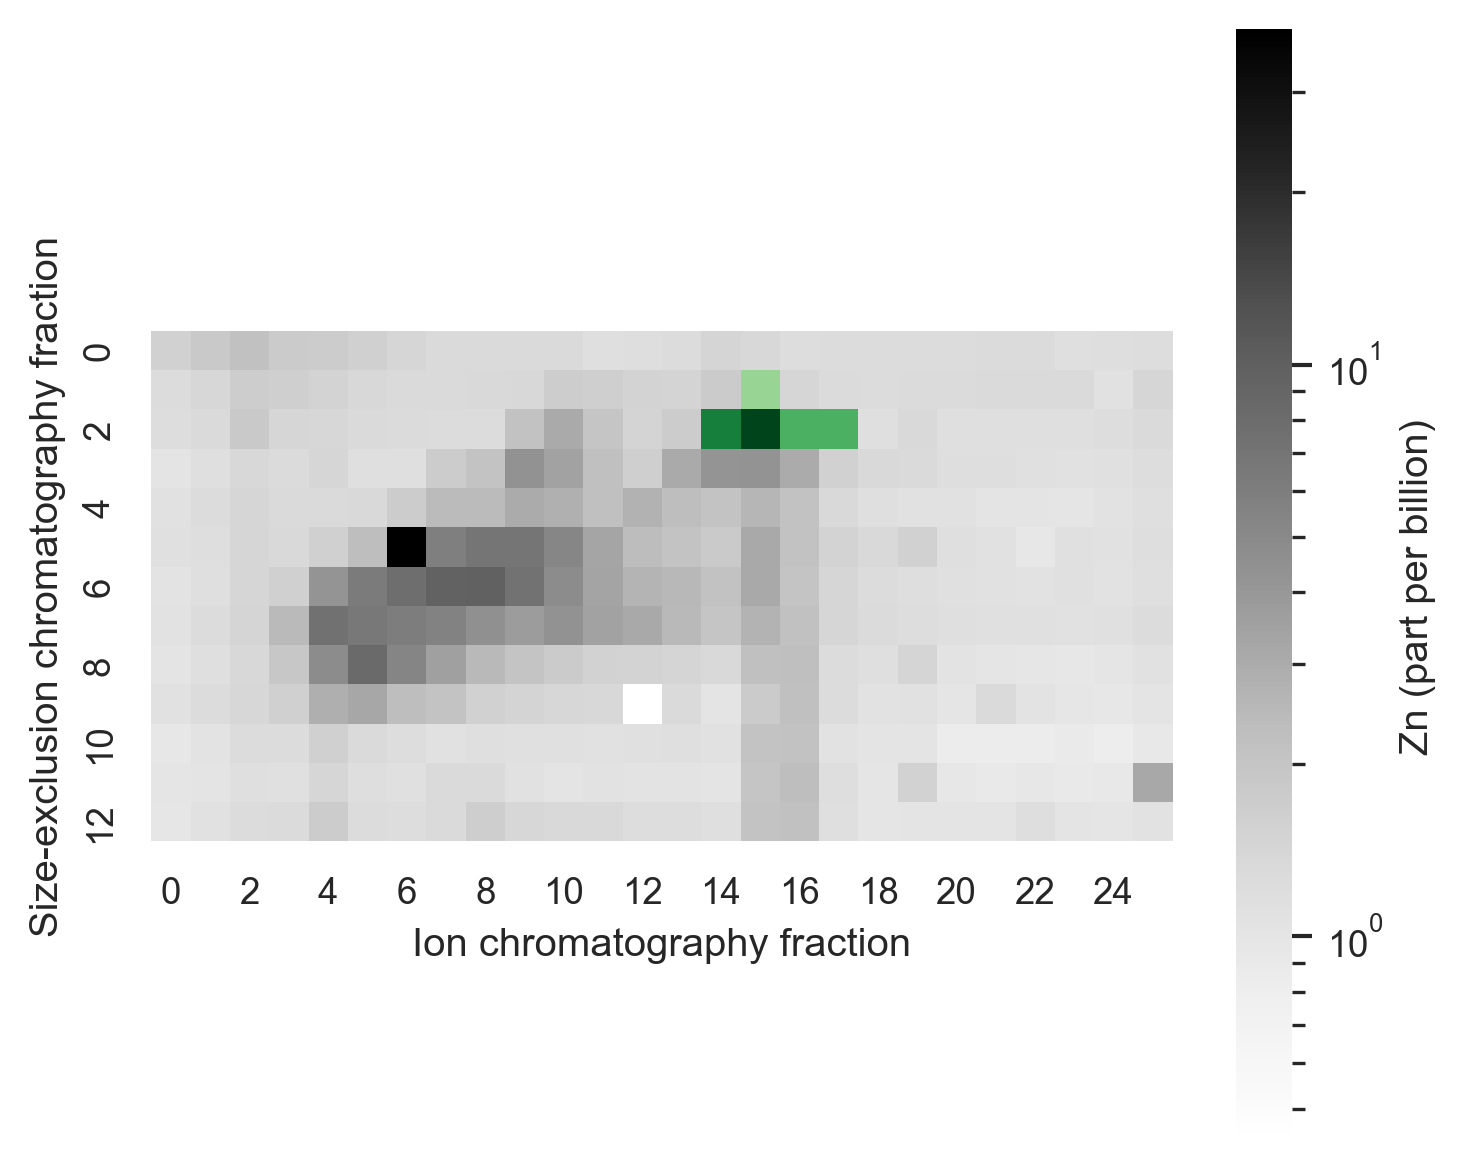

In [19]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(5, 4))

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot("56Fe", "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True, norm=LogNorm(), cbar_kws={'label': 'Zn (part per billion)'})
sns.heatmap(prot_df.pivot("rpmE", "x", "y", )[:, 1:], mask=(prot_df.pivot("rpmE", "x", "y", ) < 1).to_numpy()[:, 1:],
            cmap="Greens", square=True, cbar=False, vmin=0,  cbar_kws={'label': 'RpmE (spectral count)'})

# change x and y axis labels
plt.ylabel("Size-exclusion chromatography fraction")
plt.xlabel("Ion chromatography fraction")

# plt.xlim([0, 27])
# plt.ylim([13,0])

plt.tight_layout()

# save as png and svg
# plt.savefig("figures/zn_rpme.png")
# plt.savefig("figures/zn_rpme.svg")


# Check out some data

In [20]:
prot_df.filter((pl.col("y") == 7) & (pl.col("x") == 13)).melt(id_vars=["Experiment", "x", "y"], variable_name="Gene", value_name="Intensity")

Experiment,x,y,Gene,Intensity
str,i64,i64,str,i64
"""600to650_8""",13,7,"""tufB""",44
"""600to650_8""",13,7,"""rplC""",8
"""600to650_8""",13,7,"""rpsE""",18
"""600to650_8""",13,7,"""fliC""",37
"""600to650_8""",13,7,"""groL""",55
…,…,…,…,…
"""600to650_8""",13,7,"""ygaC""",0
"""600to650_8""",13,7,"""ycaK""",0
"""600to650_8""",13,7,"""miaA""",0


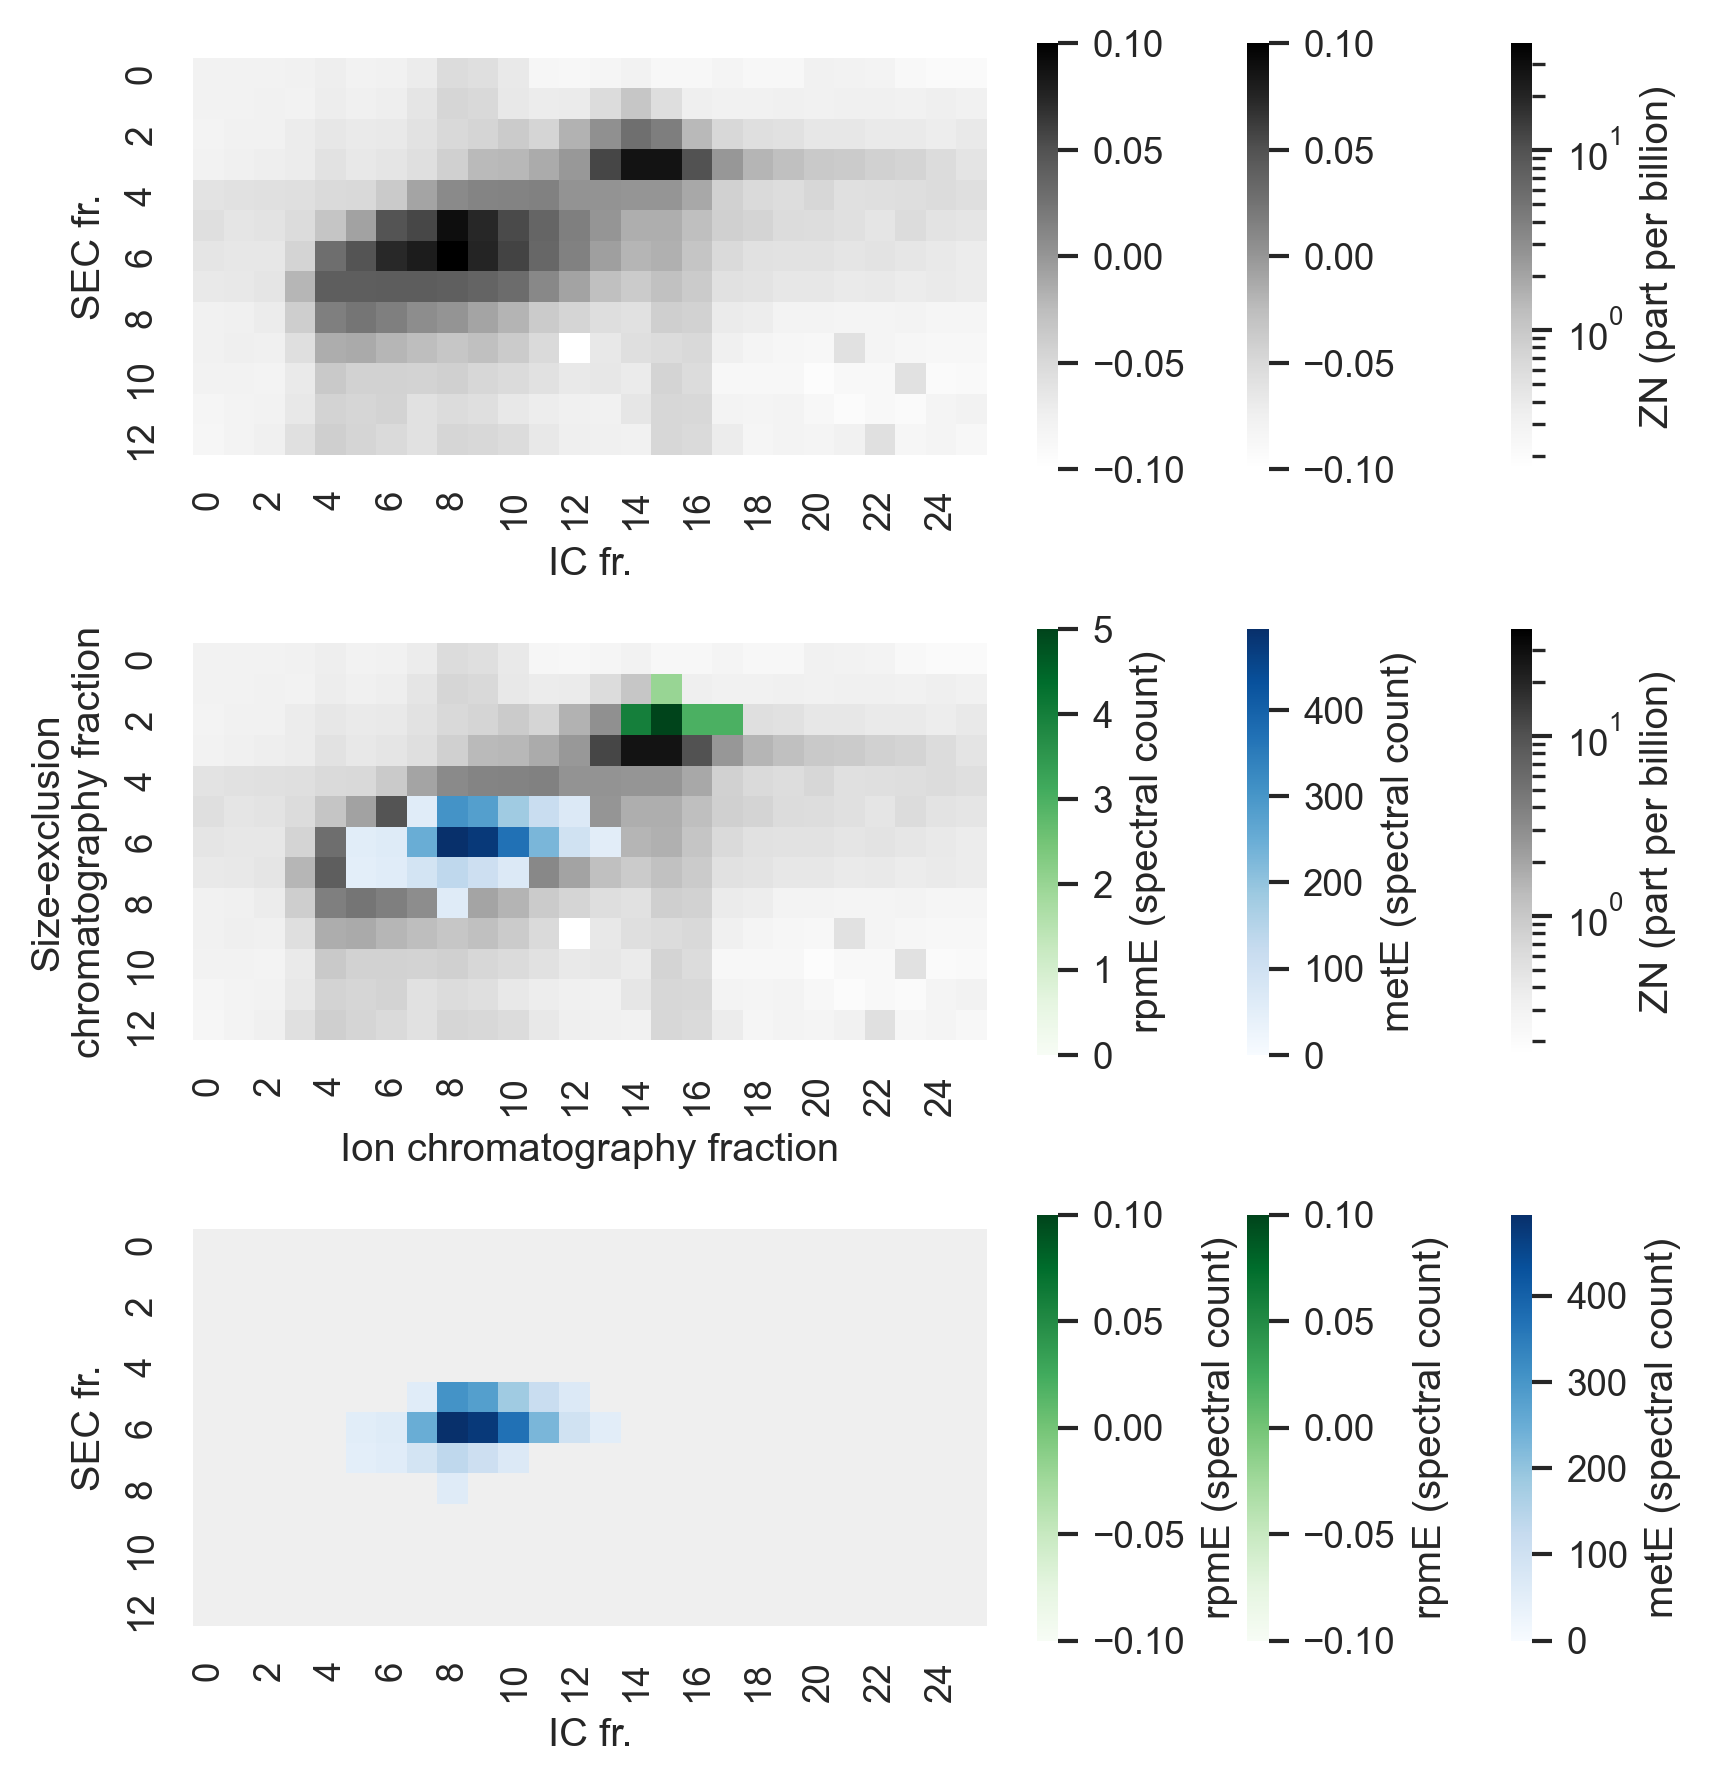

In [21]:
from matplotlib.colors import LogNorm
# plt.figure(figsize=(12, 6))

f, ax = plt.subplots(3,1, figsize=(6, 6))

gene = "metE"
gene2 = "rpmE"
metal = "66Zn"
metal_translated = isotope_element_mapping[metal]

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot(metal, "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True,
            norm=LogNorm(), cbar_kws={'label': f'{metal_translated} (part per billion)'}, ax=ax[0])
sns.heatmap(prot_df.pivot(gene, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene, "x", "y", ) < 1000).to_numpy()[:, 1:],
            cmap="Grays", square=True, cbar=True, vmin=0,  cbar_kws={'label': f' '}, ax=ax[0])
sns.heatmap(prot_df.pivot(gene, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene, "x", "y", ) < 1000).to_numpy()[:, 1:],
            cmap="Grays", square=True, cbar=True, vmin=0,  cbar_kws={'label': f' '}, ax=ax[0])

# add x and y labels
ax[0].set_ylabel("SEC fr.")
ax[0].set_xlabel("IC fr.")


sns.heatmap(metal_join_df.pivot(metal, "x", "y", )[:, 1:], cmap="Grays", square=True,
            cbar=True, norm=LogNorm(), cbar_kws={'label': f'{metal_translated} (part per billion)'}, ax=ax[1])
sns.heatmap(prot_df.pivot(gene, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene, "x", "y", ) < 50).to_numpy()[:, 1:],
            cmap="Blues", square=True, cbar=True, vmin=0,  cbar_kws={'label': f'{gene} (spectral count)'}, ax=ax[1])
sns.heatmap(prot_df.pivot(gene2, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene2, "x", "y", ) < 1).to_numpy()[:, 1:],
            cmap="Greens", square=True, cbar=True, vmin=0,  cbar_kws={'label': f'{gene2} (spectral count)'}, ax=ax[1])

# add x and y labels
ax[1].set_ylabel("Size-exclusion\nchromatography fraction")
ax[1].set_xlabel("Ion chromatography fraction")

sns.heatmap(prot_df.pivot(gene, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene, "x", "y", ) < 50).to_numpy()[:, 1:],
            cmap="Blues", square=True, cbar=True, vmin=0,  cbar_kws={'label': f'{gene} (spectral count)'}, ax=ax[2])
sns.heatmap(prot_df.pivot(gene2, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene2, "x", "y", ) < 50).to_numpy()[:, 1:],
            cmap="Greens", square=True, cbar=True, vmin=0,  cbar_kws={'label': f'{gene2} (spectral count)'}, ax=ax[2])
sns.heatmap(prot_df.pivot(gene2, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene2, "x", "y", ) < 5000).to_numpy()[:, 1:],
            cmap="Greens", square=True, cbar=True, vmin=0,  cbar_kws={'label': f'{gene2} (spectral count)'}, ax=ax[2])

# add x and y labels
ax[2].set_ylabel("SEC fr.")
ax[2].set_xlabel("IC fr.")
ax[2].grid(False)

# set a gray background for ax[2]
ax[2].set_facecolor("#EFEFEF")

# add subplot titles
# ax[0].set_title(f"Zn-66 distribution")
# ax[1].set_title(f"{gene} distribution overlaid on {metal_translated}")

plt.tight_layout()

# save as png and svg
# plt.savefig("figures/cu.png")


# Identify protein responsible for unknown peak

In [22]:
description_df = prot_df_raw.select(["Identified Proteins (1235)", "Accession Number"])

description_df = gene_df.join(description_df, on="Accession Number")

# rename Identified Proteins (1235) to "Description"
description_df = description_df.rename({"Identified Proteins (1235)": "Description", "Gene Name": "Gene"})

# Add new column, "is unknown function", 
description_df = description_df.with_columns(pl.Series(name="is unknown function", values=[1 if desc.startswith("y") else 0 for desc in description_df["Gene"]]))

description_df.filter(pl.col("is unknown function") == 1)

Accession Number,Gene,Description,is unknown function
str,str,str,i64
"""AAC74534.1""","""yncE""","""ATP-binding protein, periplasm…",1
"""AAC74287.1""","""ychF""","""catalase inhibitor protein; AT…",1
"""AAC74934.1""","""yebC""","""UPF0082 family protein [Escher…",1
"""AAC74850.2""","""yeaD""","""D-hexose-6-phosphate epimerase…",1
"""AAC76668.1""","""yicC""","""UPF0701 family protein [Escher…",1
…,…,…,…
"""AAC74609.1""","""ydeI""","""hydrogen peroxide resistance O…",1
"""AAC74504.2""","""ydcI""","""putative DNA-binding transcrip…",1
"""AAC74995.1""","""yedD""","""lipoprotein [Escherichia coli …",1


# Calculate uncertainty

<Axes: ylabel='Count'>

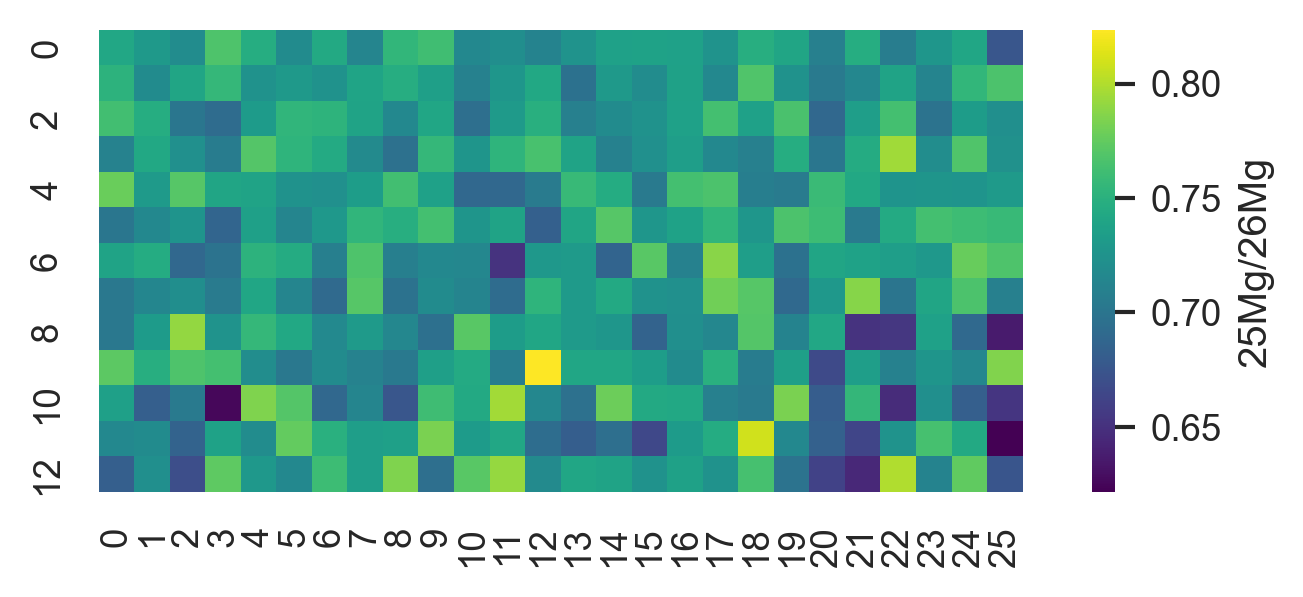

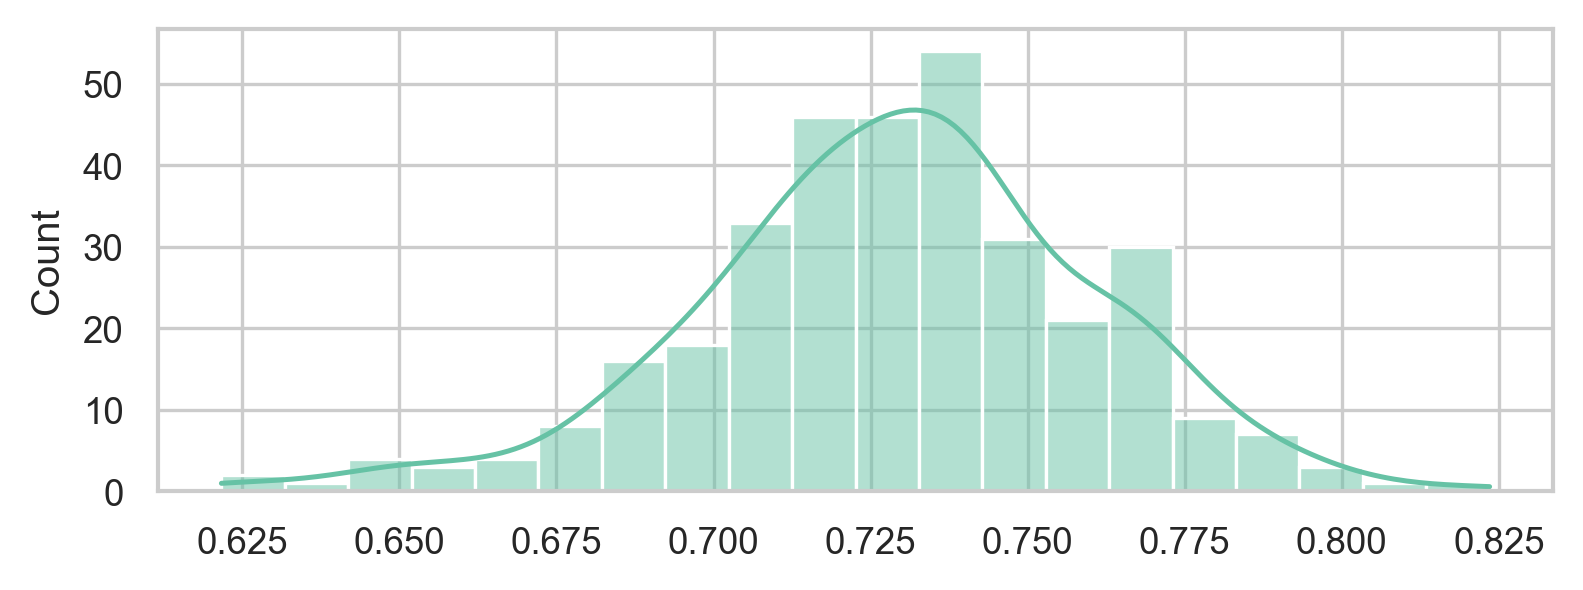

In [23]:
# get 56Fe and 57Fe 

Fe56 = metal_join_df.pivot("25Mg", "x", "y", )[:, 1:].to_numpy()
Fe57 = metal_join_df.pivot("26Mg", "x", "y", )[:, 1:].to_numpy()

# calculate the uncertainty
Fe_uncertainty = Fe56 / Fe57

# plot
plt.figure(figsize=(6, 2))
sns.heatmap(Fe_uncertainty, cmap="viridis", square=True, cbar=True, cbar_kws={'label': '25Mg/26Mg'})

# make a hist of the values
plt.figure(figsize=(6, 2))
sns.histplot(Fe_uncertainty.flatten(), bins=20, kde=True)


(0.625, 0.825)

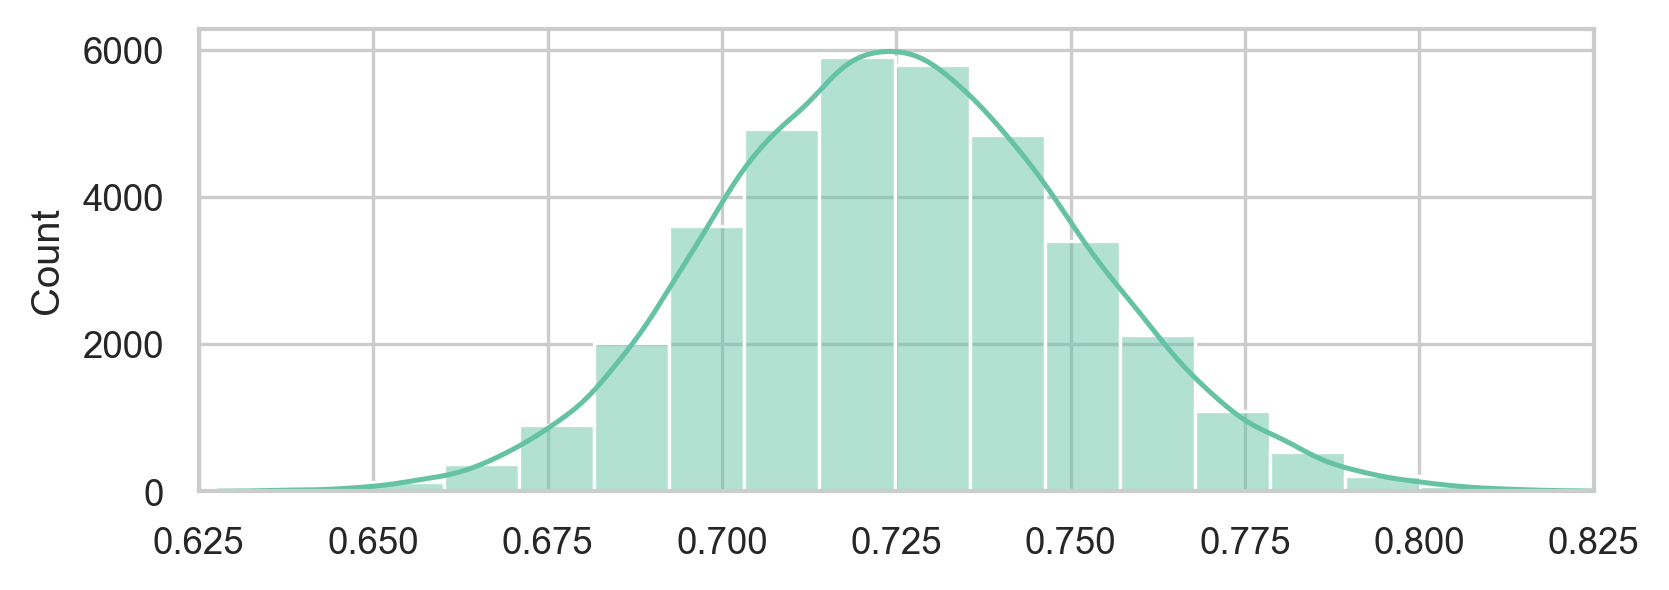

In [24]:
# simulate the ratio of two random numbers.
n_samples = 36000
Fe56 = np.random.normal(0.725, 0.025*0.725, n_samples)
Fe57 = np.random.normal(1, 0.025, n_samples)

ratio = Fe56 * np.reciprocal(Fe57)

plt.figure(figsize=(6, 2))
sns.histplot(ratio.flatten(), bins=20, kde=True)
plt.xlim(0.625, 0.825)

In [31]:
joined_df = (prot_df.select(pl.col(["metE", "x", "y"])).filter(pl.col("metE") > 10).join(metal_join_df.select(pl.col(["66Zn", "111Cd", "60Ni", "x", "y"])), on=["x", "y"]).with_columns((pl.col("111Cd")/pl.col("66Zn")).alias("Cd_Zn_ratio")).with_columns((pl.col("60Ni")/pl.col("66Zn")).alias("Ni_Zn_ratio")))

joined_df

metE,x,y,66Zn,111Cd,60Ni,Cd_Zn_ratio,Ni_Zn_ratio
i64,i64,i64,f64,f64,f64,f64,f64
16,8,6,2.093228,0.013651,0.520659,0.006521,0.248735
14,8,7,9.531077,0.098173,0.609402,0.0103,0.063938
56,8,8,11.806997,0.113278,1.002586,0.009594,0.084915
305,8,9,29.884542,0.092219,2.016631,0.003086,0.067481
281,8,10,19.399573,0.063754,1.003024,0.003286,0.051703
…,…,…,…,…,…,…,…
18,12,7,1.47303,0.004735,0.532265,0.003214,0.36134
22,12,8,1.275046,0.005436,0.505859,0.004264,0.396737
41,12,9,1.040094,0.006313,0.45735,0.00607,0.43972


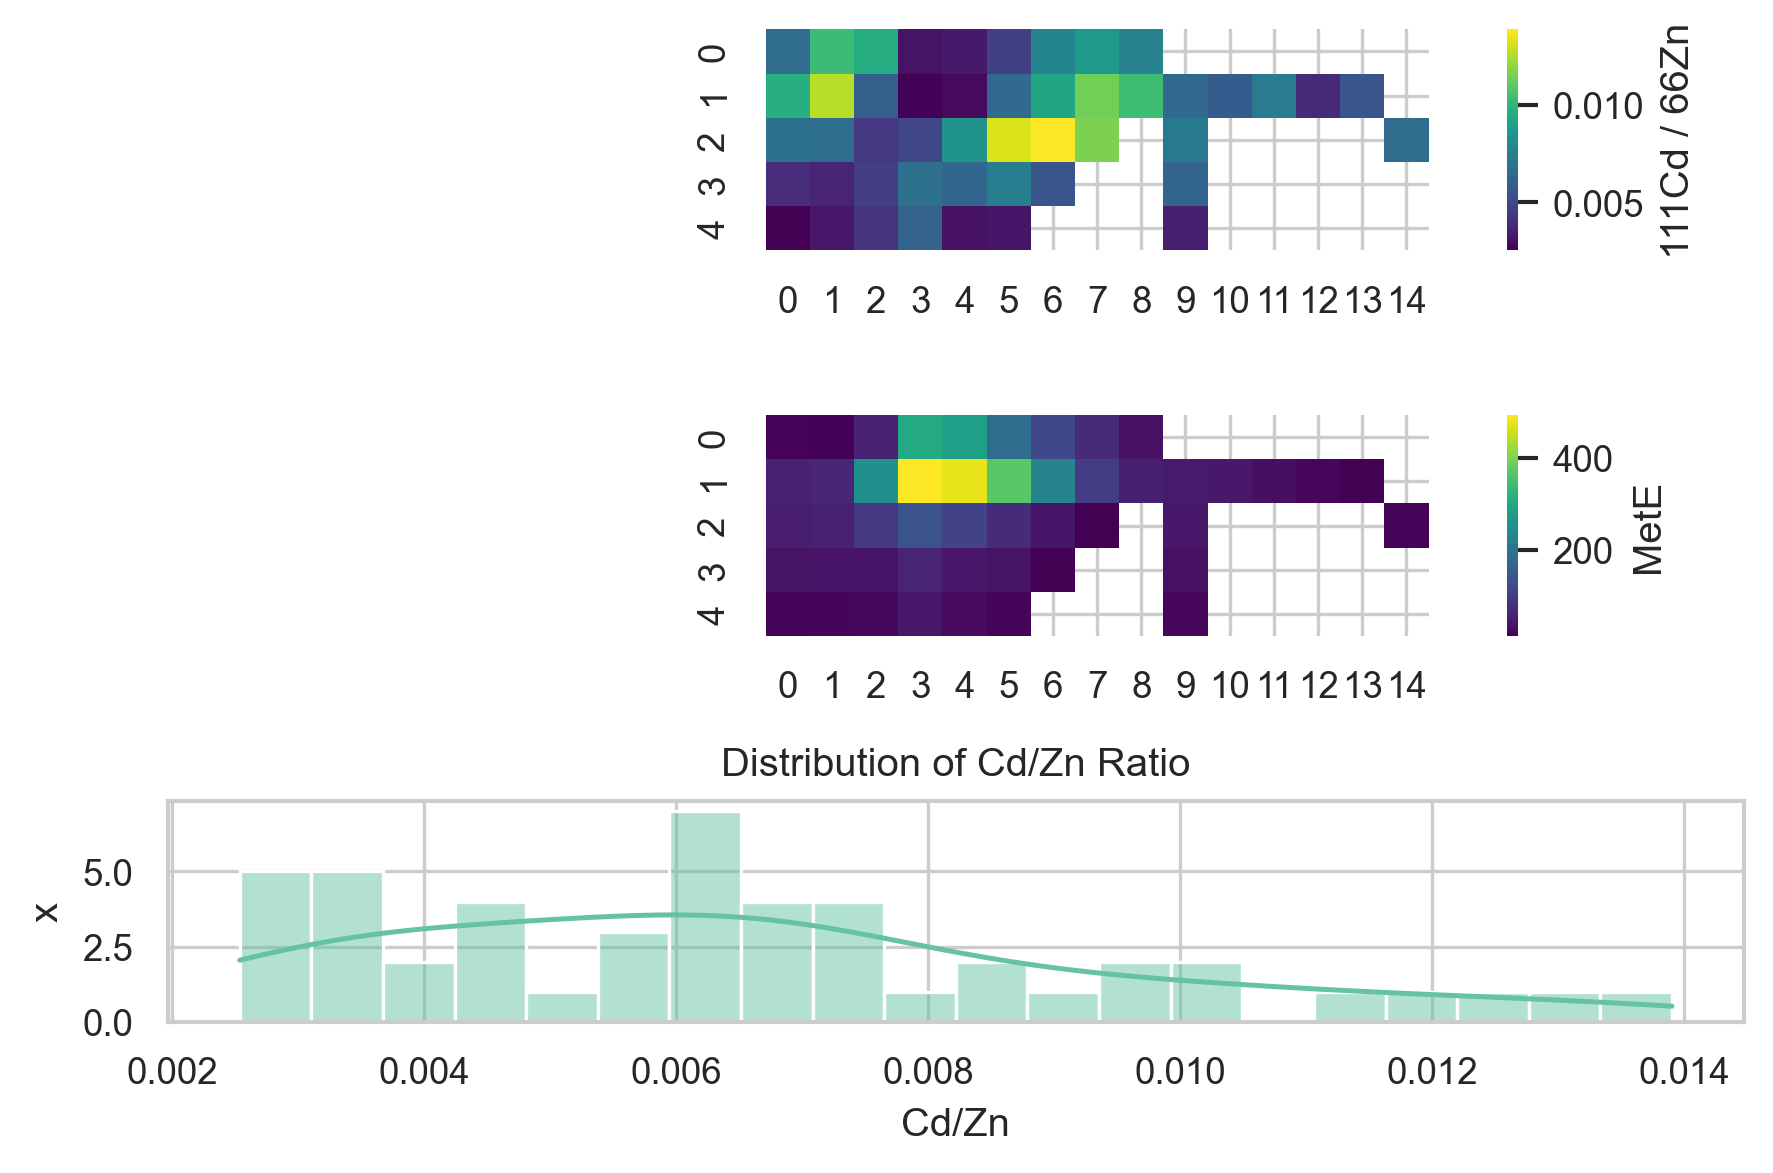

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

cd_zn_grid = joined_df.pivot(index="x", columns="y", values="Cd_Zn_ratio")
cd_zn_array = cd_zn_grid[:, 1:].to_numpy()

# plt.figure(figsize=(6, 4))
#firstheat
f, ax = plt.subplots(3, 1, figsize=(6, 4))
sns.heatmap(cd_zn_array, cmap="viridis", square=True, cbar=True, cbar_kws={'label': '111Cd / 66Zn'}, ax=ax[0])
plt.title("Cd/Zn Ratio Heatmap")
plt.xlabel("y")
plt.ylabel("x")
plt.tight_layout()

#secondheat
metE_grid = joined_df.pivot(index="x", columns="y", values="metE")
metE_array = metE_grid[:, 1:].to_numpy()

sns.heatmap(metE_array, cmap="viridis", square=True, cbar=True, cbar_kws={'label': 'MetE'}, ax=ax[1])
plt.title("MetE Ratio Heatmap")
plt.xlabel("y")
plt.ylabel("x")
plt.tight_layout()

# Histogram of all ratio values
sns.histplot(cd_zn_array.flatten(), bins=20, kde=True, ax = ax[2])
plt.title("Distribution of Cd/Zn Ratio")
plt.xlabel("Cd/Zn")
plt.tight_layout()

plt.show()

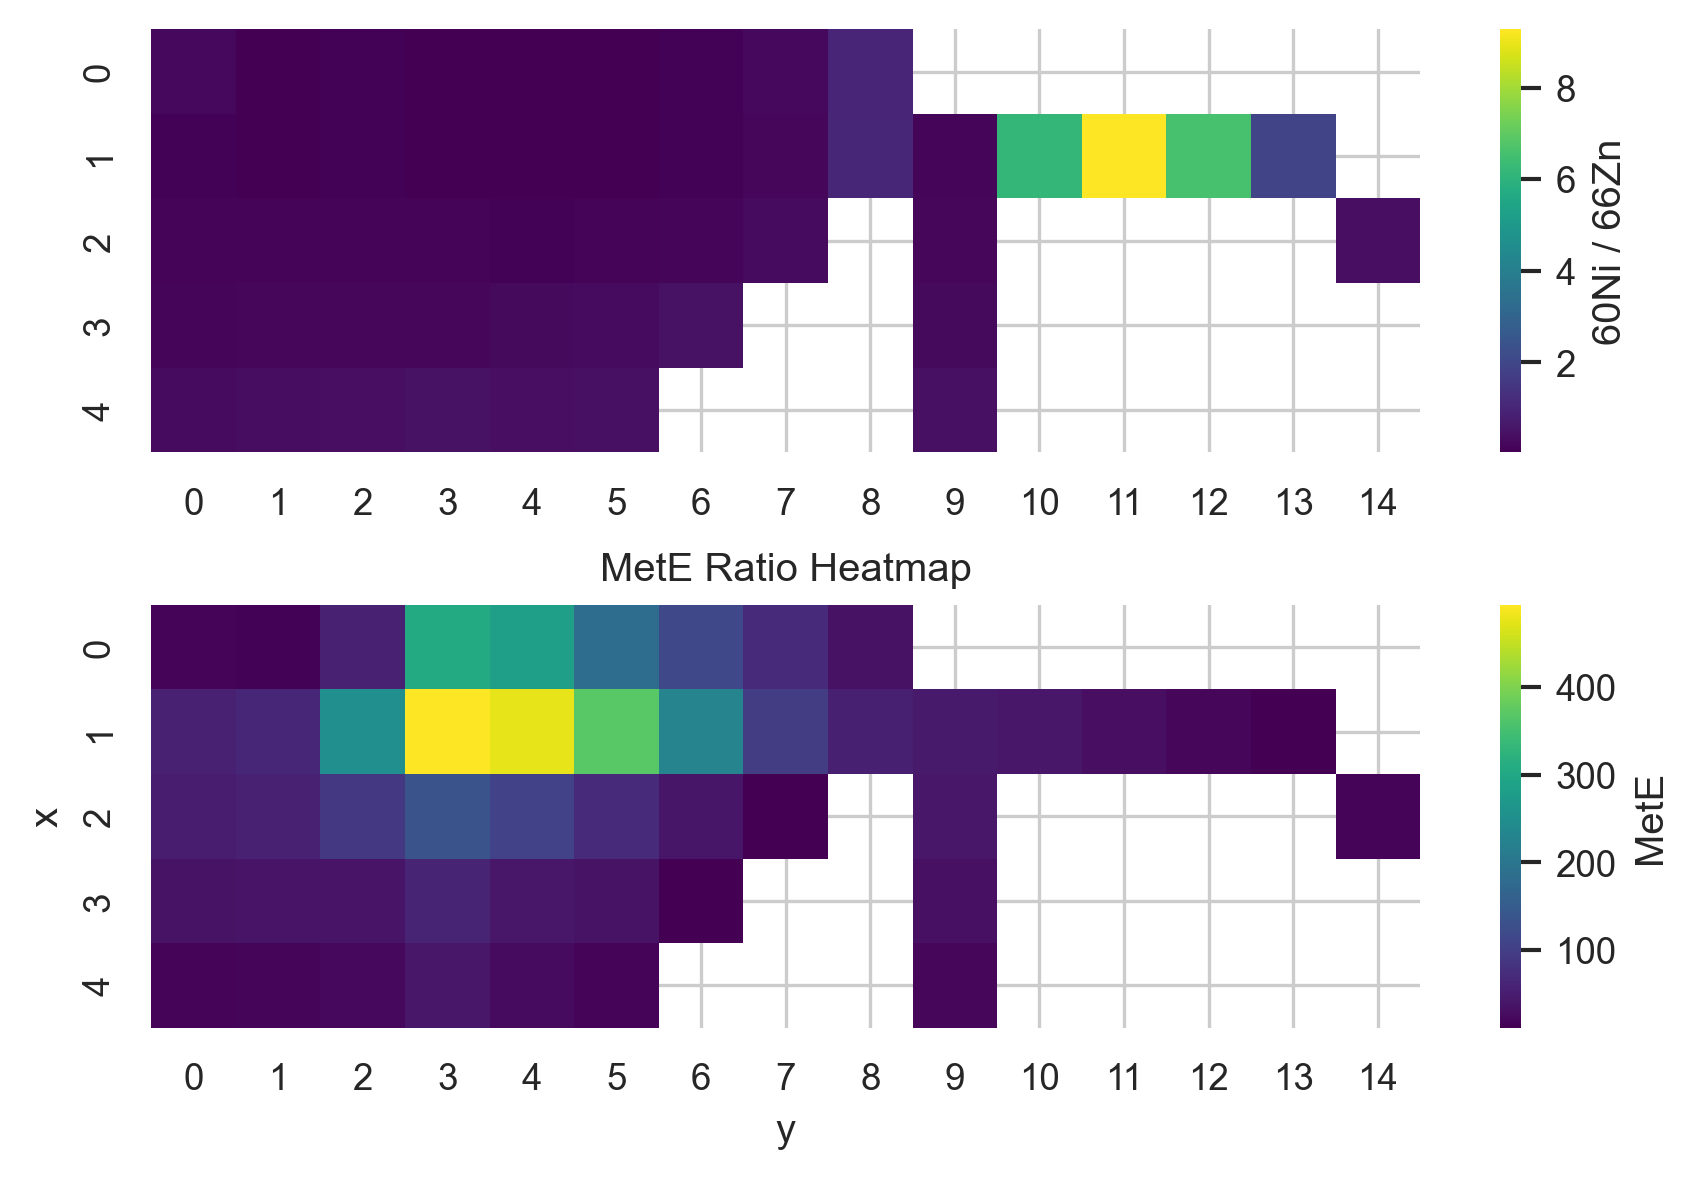

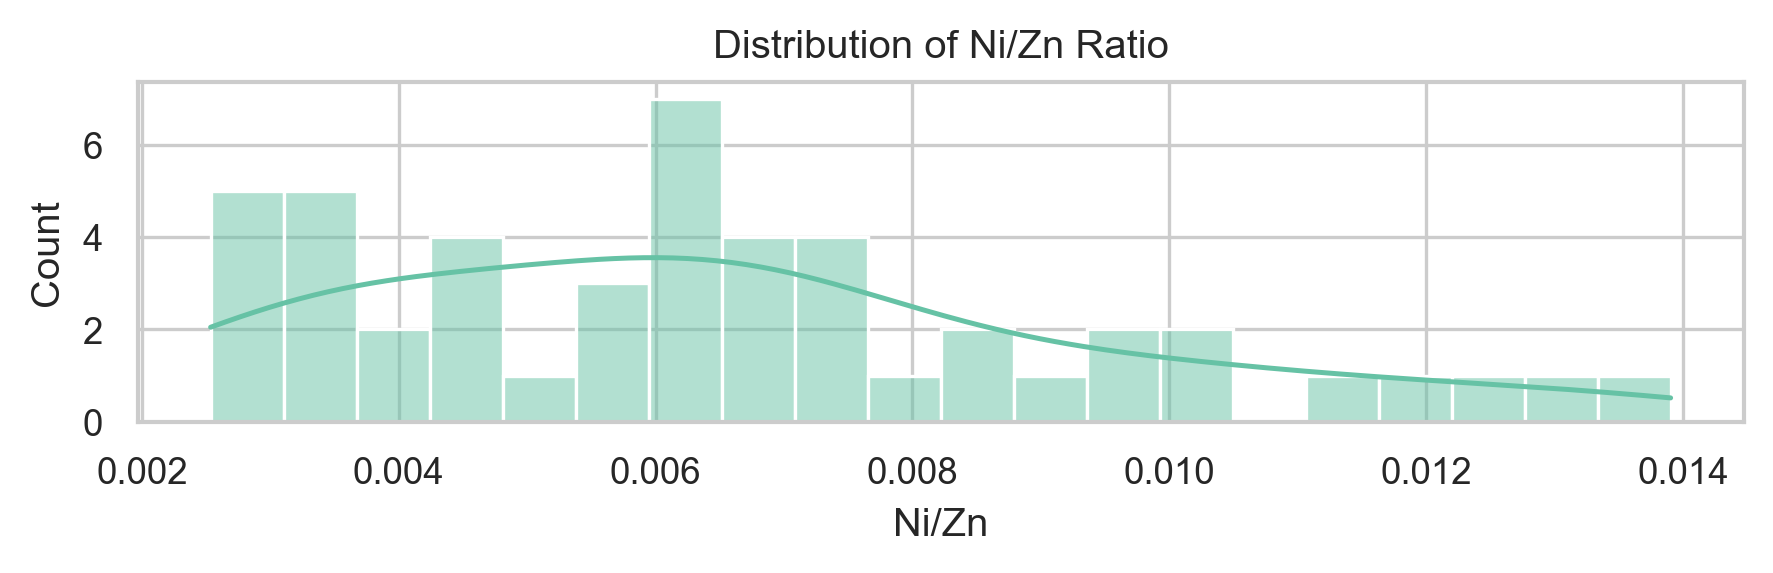

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

ni_zn_grid = joined_df.pivot(index="x", columns="y", values="Ni_Zn_ratio")
ni_zn_array = ni_zn_grid[:, 1:].to_numpy()


f, ax = plt.subplots(2, 1, figsize=(6, 4))
sns.heatmap(ni_zn_array, cmap="viridis", square=True, cbar=True, cbar_kws={'label': '60Ni / 66Zn'}, ax=ax[0])
plt.title("Ni/Zn Ratio Heatmap")
plt.xlabel("y")
plt.ylabel("x")
plt.tight_layout()

#secondheat
metE_grid = joined_df.pivot(index="x", columns="y", values="metE")
metE_array = metE_grid[:, 1:].to_numpy()

sns.heatmap(metE_array, cmap="viridis", square=True, cbar=True, cbar_kws={'label': 'MetE'}, ax=ax[1])
plt.title("MetE Ratio Heatmap")
plt.xlabel("y")
plt.ylabel("x")
plt.tight_layout()

# Histogram of all ratio values
plt.figure(figsize=(6, 2))
sns.histplot(cd_zn_array.flatten(), bins=20, kde=True)
plt.title("Distribution of Ni/Zn Ratio")
plt.xlabel("Ni/Zn")
plt.tight_layout()

plt.show()

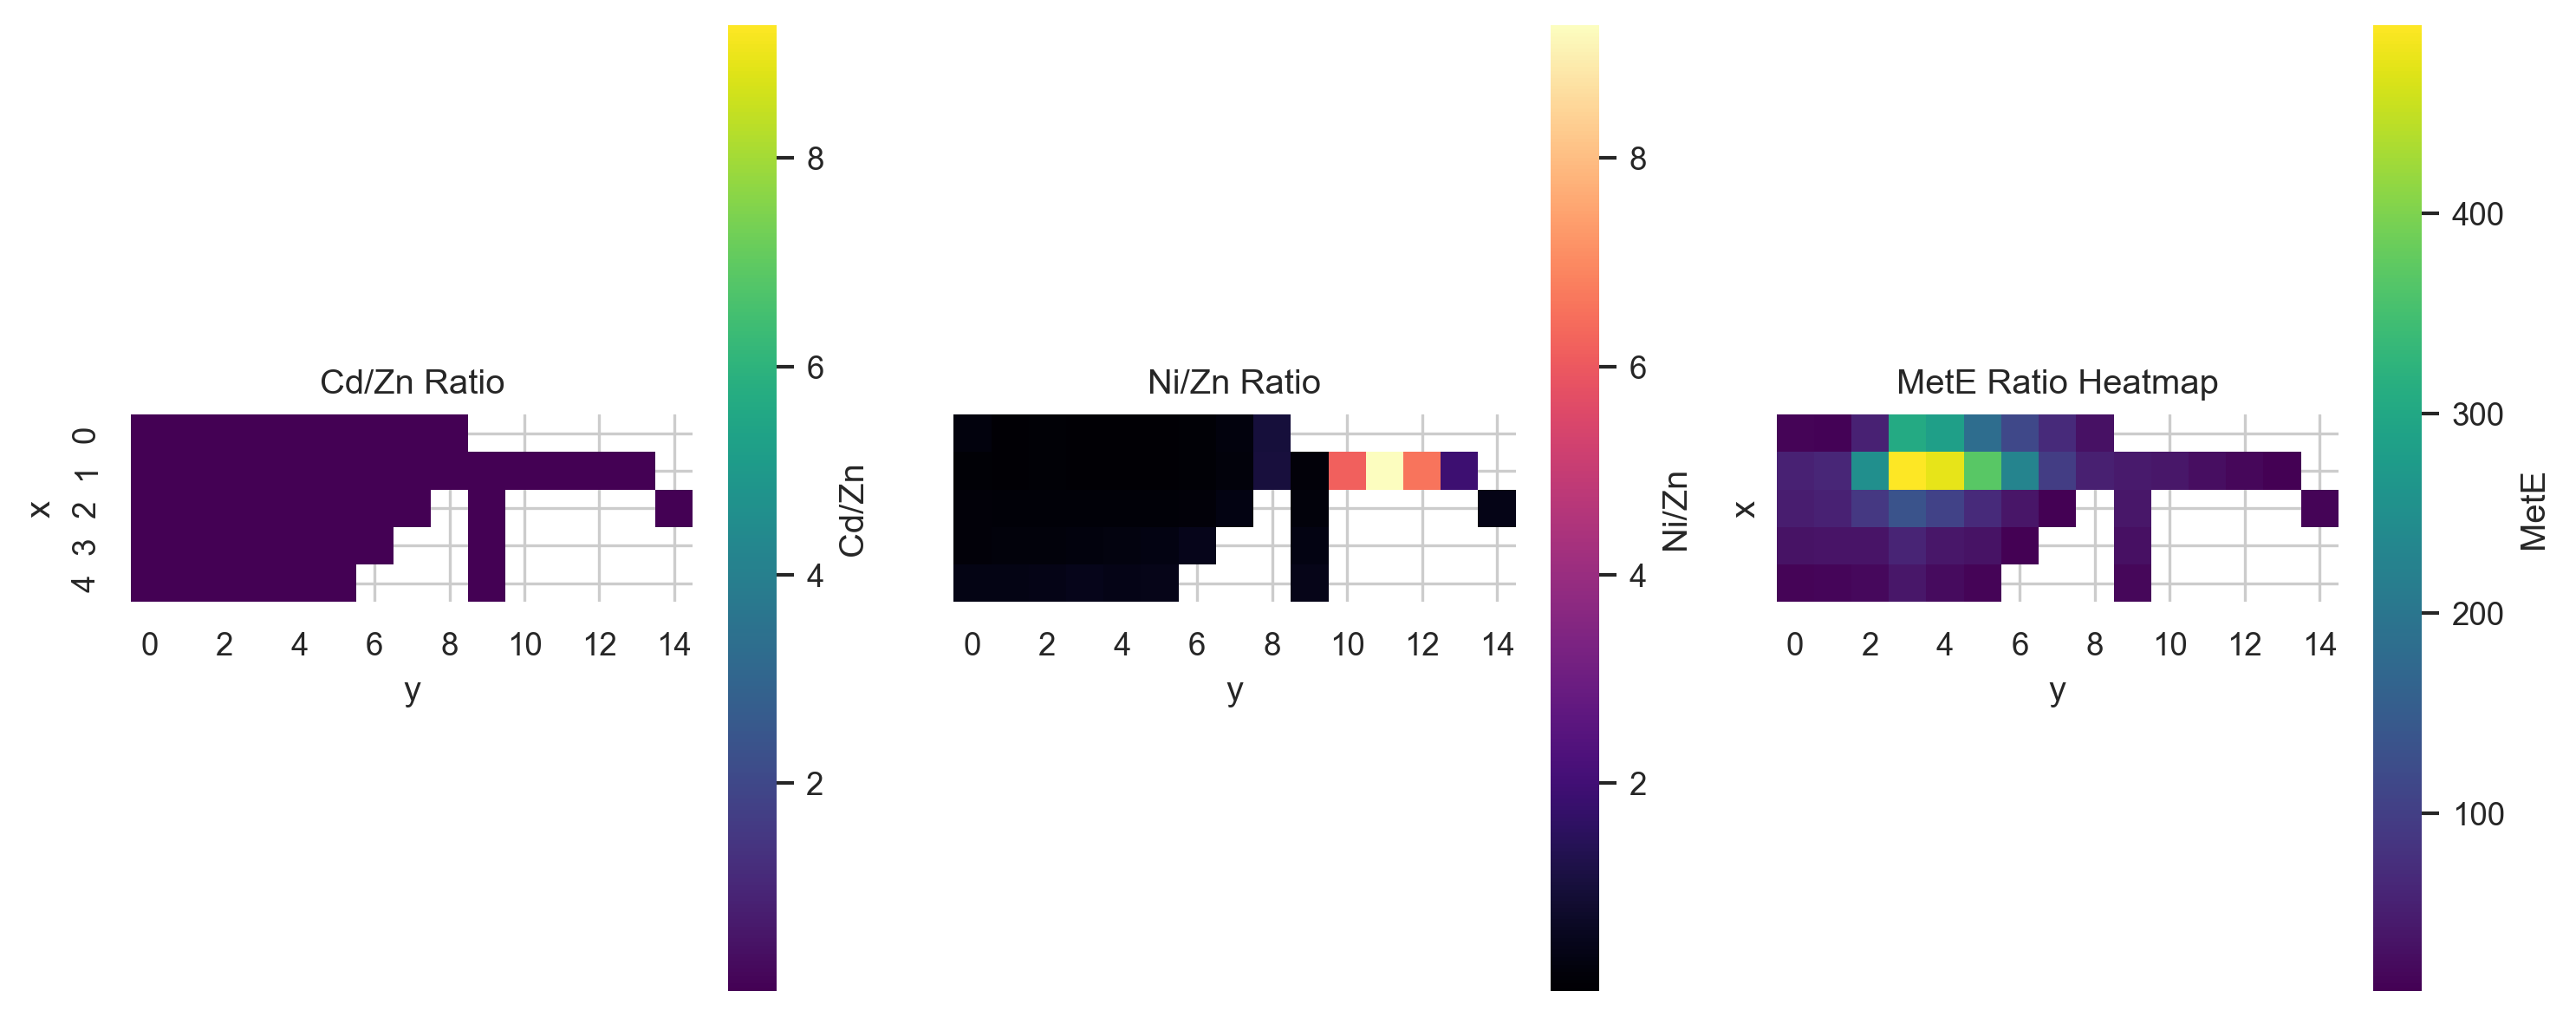

In [37]:
# Pivot each ratio
cd_zn_grid = joined_df.pivot(index="x", columns="y", values="Cd_Zn_ratio")
cd_zn_array = cd_zn_grid[:, 1:].to_numpy()

ni_zn_grid = joined_df.pivot(index="x", columns="y", values="Ni_Zn_ratio")
ni_zn_array = ni_zn_grid[:, 1:].to_numpy()

combined_min = np.nanmin([cd_zn_array, ni_zn_array])
combined_max = np.nanmax([cd_zn_array, ni_zn_array])

# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)

sns.heatmap(cd_zn_array, ax=axes[0], cmap="viridis", square=True, vmin=combined_min, vmax=combined_max, cbar=True, cbar_kws={'label': 'Cd/Zn'})
axes[0].set_title("Cd/Zn Ratio")
axes[0].set_xlabel("y")
axes[0].set_ylabel("x")

sns.heatmap(ni_zn_array, ax=axes[1], cmap="magma", square=True, vmin=combined_min, vmax=combined_max,cbar=True, cbar_kws={'label': 'Ni/Zn'})
axes[1].set_title("Ni/Zn Ratio")
axes[1].set_xlabel("y")

metE_grid = joined_df.pivot(index="x", columns="y", values="metE")
metE_array = metE_grid[:, 1:].to_numpy()

sns.heatmap(metE_array, cmap="viridis", square=True, cbar=True, cbar_kws={'label': 'MetE'}, ax=axes[2])
plt.title("MetE Ratio Heatmap")
plt.xlabel("y")
plt.ylabel("x")
plt.tight_layout()


plt.tight_layout()
plt.show()
#thought this was interesting to show how much higher the Ni/Zn ratio is

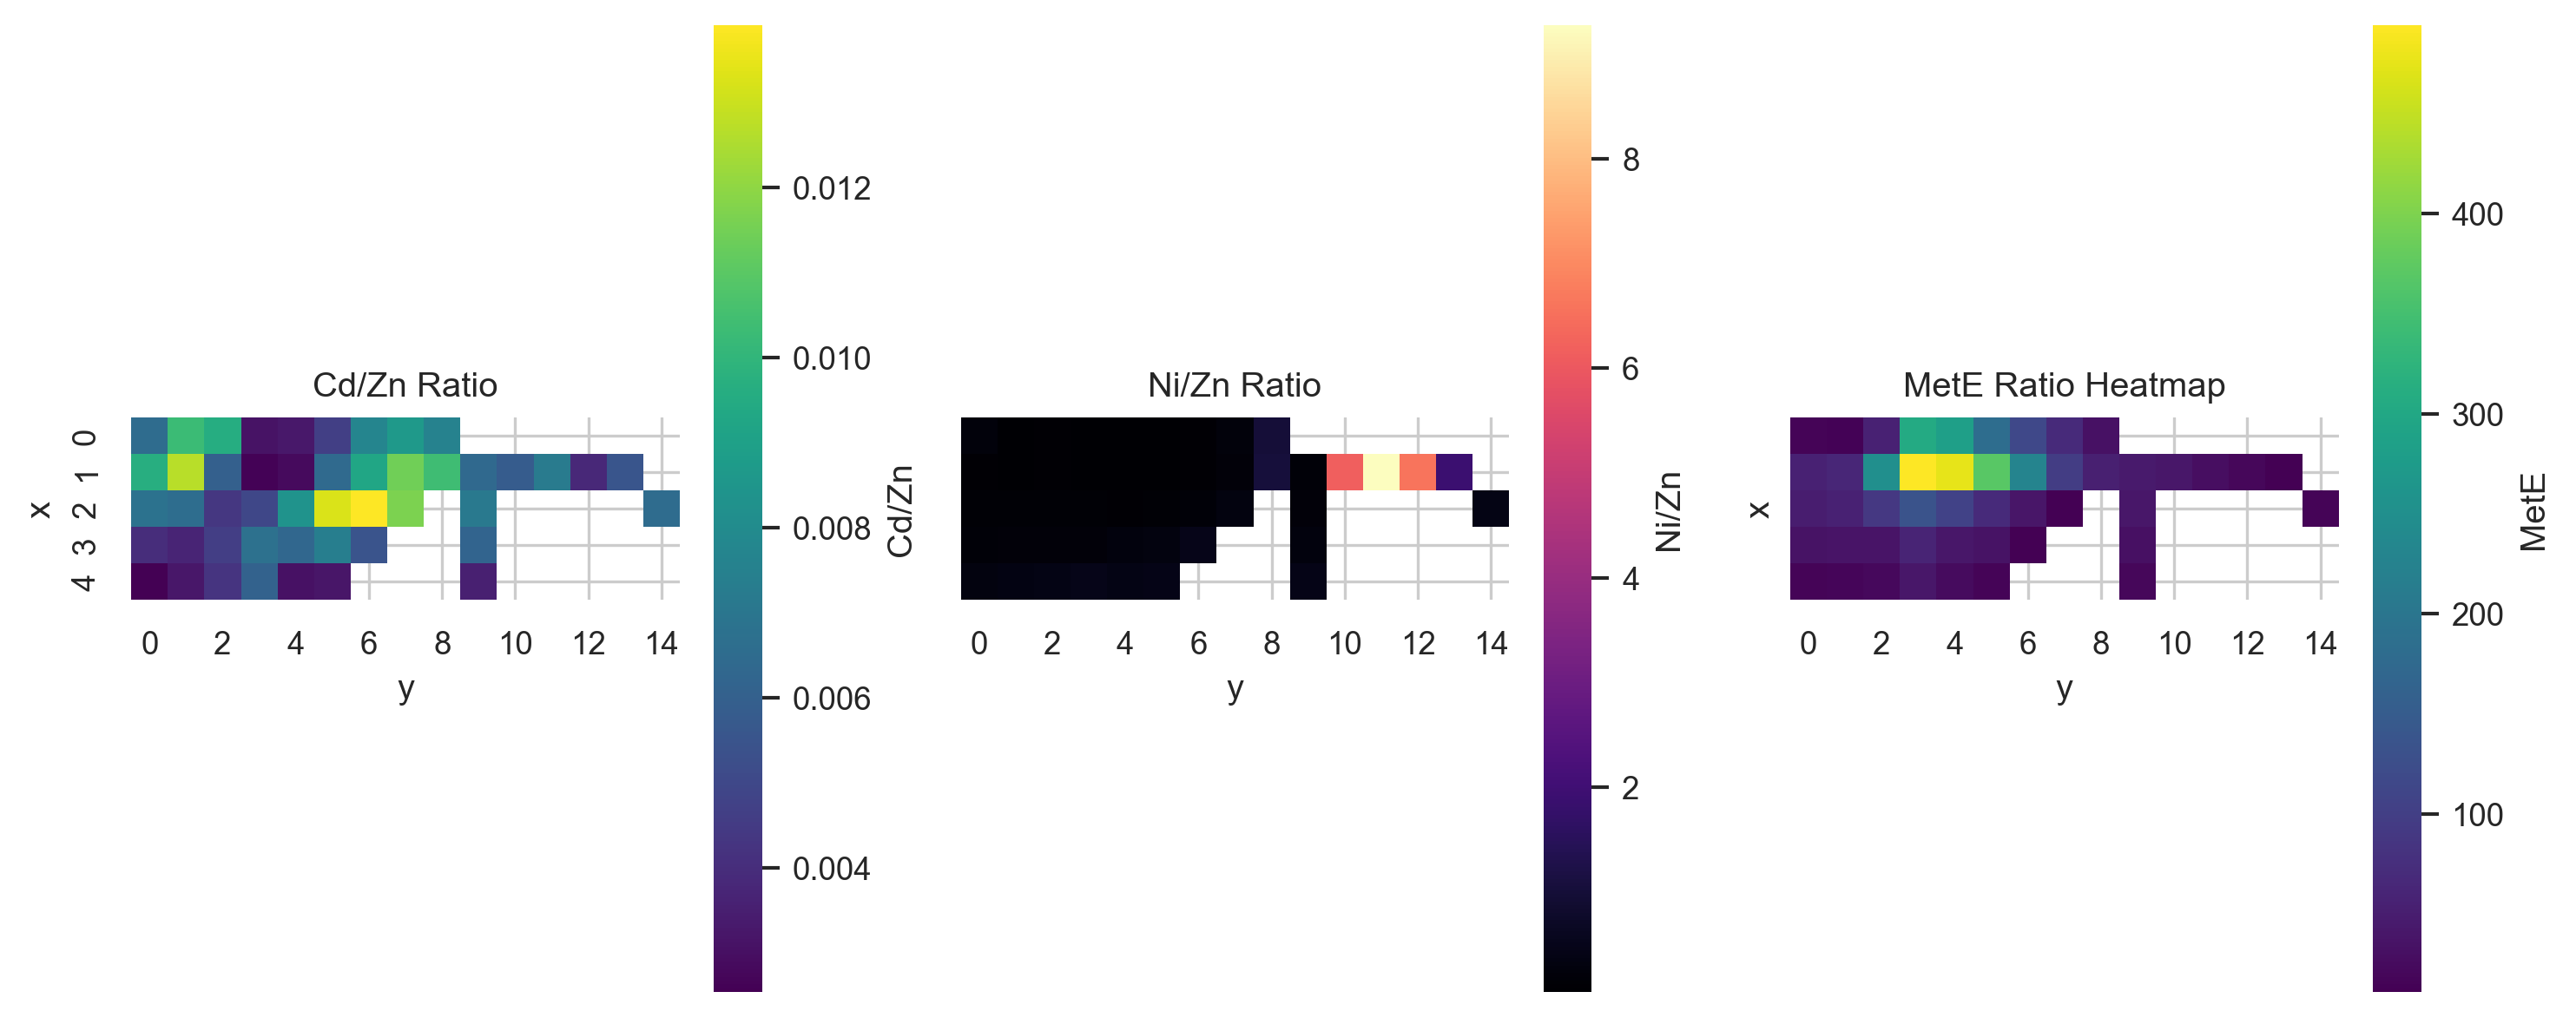

In [39]:
# Pivot each ratio
cd_zn_grid = joined_df.pivot(index="x", columns="y", values="Cd_Zn_ratio")
cd_zn_array = cd_zn_grid[:, 1:].to_numpy()

ni_zn_grid = joined_df.pivot(index="x", columns="y", values="Ni_Zn_ratio")
ni_zn_array = ni_zn_grid[:, 1:].to_numpy()

# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)

sns.heatmap(cd_zn_array, ax=axes[0], cmap="viridis", square=True, cbar=True, cbar_kws={'label': 'Cd/Zn'})
axes[0].set_title("Cd/Zn Ratio")
axes[0].set_xlabel("y")
axes[0].set_ylabel("x")

sns.heatmap(ni_zn_array, ax=axes[1], cmap="magma", square=True, cbar=True, cbar_kws={'label': 'Ni/Zn'})
axes[1].set_title("Ni/Zn Ratio")
axes[1].set_xlabel("y")

metE_grid = joined_df.pivot(index="x", columns="y", values="metE")
metE_array = metE_grid[:, 1:].to_numpy()

sns.heatmap(metE_array, cmap="viridis", square=True, cbar=True, cbar_kws={'label': 'MetE'}, ax=axes[2])
plt.title("MetE Ratio Heatmap")
plt.xlabel("y")
plt.ylabel("x")


plt.tight_layout()
plt.show()
#no adjusted color scheme

In [30]:
 metal_join_df

Experiment,25Mg,26Mg,29Si,31P,34S,44Ca,71Ga,73Ge,27Al,47Ti,48Ti,51V,52Cr,55Mn,56Fe,57Fe,59Co,60Ni,63Cu,66Zn,75As,77Se,95Mo,111Cd,115In,118Sn,121Sb,182W,202Hg,208Pb,209Bi,x,y
str,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
"""100to150_2""",2424,3268,358150,658,10318,10690,4,2,1.28963,0.105418,0.23391,0.20744,0.437886,0.994977,1.57962,1.247038,0.036616,0.831977,0.229864,0.30864,0.014489,0.200652,0.081377,0.001336,-13.40308,0.038449,0.004793,12.471815,2.004132,0.00593,4.187315,3,1
"""100to150_3""",2404,3293,353562,737,11082,10791,7,4,1.434155,0.086251,0.26326,0.189714,0.449281,0.965916,1.851357,1.489283,0.035843,0.854022,0.242732,0.302458,0.015648,0.183931,0.081209,0.000779,-13.505967,0.040625,0.005548,12.224868,2.077455,0.006276,3.513492,3,2
"""100to150_4""",2298,3197,346458,704,10499,10289,4,4,1.605376,0.103501,0.246314,0.187535,0.473168,0.947359,2.152927,1.808355,0.035271,0.819974,0.256623,0.304706,0.024341,0.16721,0.077411,0.001781,-13.331345,0.040189,0.005903,12.101366,2.321863,0.006496,3.248776,3,3
"""100to150_5""",2420,3155,341925,690,9885,10242,1,3,1.478341,0.093918,0.238977,0.168423,0.434999,0.926318,1.782944,1.457018,0.03481,0.787764,0.273798,0.312854,0.017386,0.066884,0.079091,0.000668,-13.197517,0.038805,0.005015,13.95364,2.24854,0.006416,3.561624,3,4
"""100to150_6""",2276,3048,329445,753,10192,10398,2,1,1.46177,0.113085,0.252254,0.170305,0.443807,0.90726,1.764867,1.436532,0.036868,0.797316,0.261809,0.34882,0.016227,0.183931,0.078738,0.001002,-13.089512,0.034137,0.004616,12.348343,2.224101,0.00667,3.3691,3,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""700to800_23""",687,1066,62194,282,3446,4018,0,1,0.968749,0.067557,0.266934,0.100142,0.235307,0.12268,1.015955,0.727855,0.008304,0.205888,0.172192,0.322502,0.021042,0.265612,0.074713,0.000638,-14.964736,0.022933,0.00529,20.51376,1.913082,0.004284,5.048914,15,22
"""700to800_24""",1032,1291,63460,280,3725,5395,1,1,2.75897,0.117098,0.31536,0.101578,0.232665,0.127879,1.182385,0.9304,0.009572,0.23914,0.192601,0.541271,0.017096,0.265612,0.091301,0.000638,-15.408186,0.083402,0.005208,19.536919,1.647375,0.005147,9.42467,15,23
"""700to800_25""",576,809,65263,326,3752,3352,1,1,1.023242,0.076564,0.206102,0.107803,0.262816,0.119358,1.022619,0.776596,0.008429,0.220881,0.171453,0.253877,0.015781,0.132806,0.076556,0.001064,-15.137232,0.026768,0.004394,14.327084,1.753658,0.004305,4.039135,15,24
